# Characterizing Approximation Methods for Digital Twins in Scientific Computing

_Zachary Morrow,$^a$ Bart van Bloemen Waanders,$^a$ John D. Jakeman,$^a$ Shane A. McQuarrie,$^{a,b}$ Maher Salloum,$^a$ Nick Winovich$^a$_

_$^a$ Sandia National Laboratories_

_$^b$ Oden Institute for Computational Engineering and Sciences, University of Texas at Austin_

This Jupyter notebook contains the model problem and approximation methods for the survey paper. We consider both function and operator approximation. The model problem is time-dependent advection-diffusion in 2D. We will characterize each method based on _RISE_:

* **Robustness:** the degree to which the accuracy of an approximation remains constant as its design strategy or inputs are perturbed
* **Interpretability:** ease of explaining _to non-experts_ the effect that data, physical structure, and approximation structure have on approximation accuracy
    * The machine learning literature links _interpretability_ with _explainability_, the ability of a human to reason why the model makes the decision it does. Alternatively, one could base interpretability on _trust_ &mdash; the level of comfort with relinquishing decision-making authority to the model.
* **Scalability:** the dependence of accuracy on problem size (e.g., dimension)
* **Efficiency:** the dependence of approximation accuracy specifically on computational resources

This notebook is arranged in four major parts:

1. Preliminaries
2. Model problem and parametrization
3. Function approximation
4. Operator approximation

# Preliminaries

In [1]:
import os

# OPTIONAL: Operator inference (needed to run examples)
try:
    import rom_operator_inference as opinf
except:
    print('Could not load Operator Inference code. To run examples, see '
          'https://github.com/Willcox-Research-Group/rom-operator-inference-Python3')

# OPTIONAL: Sparse grids (needed to run examples)
try:
    import Tasmanian as tsg
except:
    print('Could not load Tasmanian. To run examples, see '
          'https://ornl.github.io/TASMANIAN/stable/')
    
# REQUIRED: numpy, scipy, matplotlib, fenics, pyapprox
import numpy as np
import numpy.linalg as la
import scipy
import matplotlib.pyplot as plt
from matplotlib import cm
import fenics as fe
import pyapprox as pya      # GPs, KL
import pyapprox.pde.karhunen_loeve_expansion as kle
import pyapprox.surrogates

# For convenience 
import warnings 
warnings.filterwarnings('ignore')
fe.set_log_level(50)

Could not load Operator Inference code. To run examples, see https://github.com/Willcox-Research-Group/rom-operator-inference-Python3
Could not load Tasmanian. To run examples, see https://ornl.github.io/TASMANIAN/stable/


### Environment variables

* set `data_folder` to a readable data directory
    * SNL users will want to connect to the `/project` space or use CEE brokered workstation
* set `scratch_folder` to an existent and writable scratch directory (default `~/scratch`)
* toggle `save_plots` if you want to save the generated plots to the `manuscript/figs/` directory

In [3]:
data_folder = '/projects/rise/data/approx_paper'
#data_folder = '../data'
scratch_folder = os.path.join(os.getenv('HOME'), 'scratch')
save_plots = not True

if not os.path.exists(scratch_folder):
    os.makedirs(scratch_folder)
if save_plots and not os.path.exists('manuscript/figs'):
    os.makedirs('manuscript/figs')

In [4]:
plt.rcParams['figure.figsize'] = [6.0, 4.0]
plt.rcParams['font.size'] = 16
plt.rcParams['figure.dpi'] = 250 if save_plots else 100
plt.rcParams['savefig.dpi'] = 250 if save_plots else 100

### Manufactured solution
To test our FEniCS implementation, we use the time-independent 2D convection-diffusion equation with $D=1$, $\mathbf{v}=\mathbf{1}$, and Neumann boundary conditions:

\begin{align*}
- \nabla^2 u + \nabla \cdot u &= g, \hspace{3.4em} \mathbf{x} \in \Omega, \\
\nabla u \cdot \mathbf{\hat{n}} &= 0, \hspace{3.4em} \mathbf{x} \in \partial\Omega, \\
\end{align*}

where $\Omega = [0,1] \times [0,1]$. We utilize the method of manufactured solutions so that

$$
u_{\text{exact}}(\mathbf{x},t) = \cos(2\pi x_1)\cos(2\pi x_2),
$$

which, after algebraic simplification, gives the source term

$$
g(\mathbf{x}) = -2\pi \sin(2\pi(x_1+x_2)) + 8\pi^2 \cos(2\pi x_1)\cos(2\pi x_2).
$$

We use quadratic elements on a rectangular mesh.

In [4]:
def manufactured_soln(num_partitions, display_plots=False):
    # Define mesh and piecewise-linear basis
    mesh = fe.UnitSquareMesh(num_partitions,num_partitions)
    V = fe.FunctionSpace(mesh,'Lagrange',2)
    
    # Set exact solution
    u_exact = fe.Expression('cos(2*M_PI*x[0])*cos(2*M_PI*x[1])', degree=4, t=0)
    
    # Previous and current solution
    u0 = fe.interpolate(u_exact, V)    # Initialize at initial profile
    u1 = fe.Function(V)
    
    # Velocity field
    W = fe.VectorFunctionSpace(mesh, 'Lagrange', 2)
    vel = fe.Function(W) 
    vel.assign(fe.project(fe.Expression(('1','1'), degree=0),W))
    
    # Set time-stepping parameters; only need one solve for time-independent problem
    dt = 0.1
    t = 0.0
    T = dt

    # Initialize variables for weak formulation
    u = fe.TrialFunction(V)
    v = fe.TestFunction(V)
    D = fe.Constant(1)
    g = fe.Expression('-2*M_PI*sin(2*M_PI*(x[0]+x[1])) + 8*M_PI*M_PI*cos(2*M_PI*x[0])*cos(2*M_PI*x[1])', 
                      degree=2, t=0)

    # Define weak formulation with linear and bilinear forms
    a = ((u*v) + dt*fe.inner(D*fe.grad(u), fe.grad(v)) + dt*fe.div(vel*u)*v)*fe.dx 
    L = u0*v*fe.dx + dt*g*v*fe.dx
    
    # time stepper (only one step)
    while (t < T):
        # Solve
        g.t = t
        u_exact.t = t
        fe.solve(a == L, u1)

        # Update
        u0.assign(u1)
        t += dt

    return fe.errornorm(u_exact, u0, 'L2')

In [5]:
errs = []
print('  Grid size (1D)  |   L^2 error   |   Ratio  |  Order  ')
print('------------------+---------------+----------+---------')
for i in range(7):
    errs.append(manufactured_soln(2 ** i))
    if i == 0:
        print('     %5d        |    %1.2e   |          |' % (2**i, errs[i]))
    else:
        print('     %5d        |    %1.2e   |   %3.3f  |  %3.2f' % 
              (2**i, errs[i], errs[i]/errs[i-1], np.log(errs[i-1]/errs[i])/np.log(2)))

  Grid size (1D)  |   L^2 error   |   Ratio  |  Order  
------------------+---------------+----------+---------
         1        |    3.01e+00   |          |
         2        |    2.24e-01   |   0.075  |  3.74
         4        |    4.15e-02   |   0.185  |  2.44
         8        |    4.72e-03   |   0.114  |  3.14
        16        |    5.59e-04   |   0.119  |  3.08
        32        |    6.89e-05   |   0.123  |  3.02
        64        |    8.60e-06   |   0.125  |  3.00


Since we use quadratic elements, the third-order convergence matches theoretical predictions. Thus, our implementation meets specs.

# Model problem and parametrization

Now we consider a more realistic 2D problem reminiscent of contaminant spread. We take $D=0.05$ and $\mathbf{v}=(3,0)^T$. On all boundaries, we have zero diffusion, so outflow is governed by $\mathbf{v}$. The source/sink term over $\Omega$ is a Gaussian with a tall, narrow peak. The initial profile is $u_0(\mathbf{x}) \equiv 0$. So our IBVP now becomes

\begin{align*}
u_t + \nabla \cdot (\mathbf{v} u) - \nabla \cdot (D \nabla u) &= g, \hspace{2em} \mathbf{x} \in \Omega,~t>0 \\
(D \nabla u) \cdot \hat{\mathbf{n}} &= 0, \hspace{2.1em} \mathbf{x} \in \partial \Omega,~t>0 \\
u(\mathbf{x},0) &= 0, \hspace{2.1em} \mathbf{x} \in \Omega
\end{align*}

where $g$ is a Gaussian with mean $\mathbf{\mu} = (0.2, 0.5)^T$ and covariance $\mathbf{\Sigma} = 0.02 \mathbf{I}$.

## Velocity parametrization

We specify the $x_1$-component of velocity as coming from a random field with mean $\bar{v}$, and set the $x_2$ component to zero. The velocity field $\mathbf{v} = (v_1, 0)$ now takes the form
\begin{equation}
    v_1 (\mathbf{x}; \mathbf{\xi}) = \bar{v} + \sigma \sum_{k=1}^d \sqrt{\lambda_k} \, \phi_k(x_1) \, \xi_k 
    \label{equ:v_KLE}
\end{equation}
where $\lambda_k$ and $\phi_k$ are eigenvalues and eigenfunctions, called Karhunen&ndash;Lo&#232;ve (KL) modes, of the operator $\mathcal{T}$, defined as
$$
\mathcal{T}[f](x) = \int_0^1 K(x, y) f(y) \, \text{d} y
$$
with covariance kernel $K(x,y)$. We use $\bar{v} = 3$, $\sigma=1$, and the squared-exponential covariance kernel with characteristic length scale $\ell = 0.25$. 

In what follows, we assume $\xi_1, \dots, \xi_d$ are uniformly distributed on $[-1,1]$ and independent. We take the quantity of interest (QoI) to be the concentration at $\mathbf{x} = (0.5, 0.5)^T$ at the final time $t=T=0.75$. We are interested in approximating the parameter-to-QoI map, i.e.
$$
f(\mathbf{\xi}) = u(0.5,0.5,T; \mathbf{\xi})
$$

In [5]:
# Convenience class, computes solution and stores QoI; contains evaluation wrapper

class AdvecDiff2D():
    '''
    Wrapper for advection-diffusion in 2D using FEniCS 
    '''
    def __init__(self, xi, num_partitions=32, T=0.75, dt=0.01, ell=0.25, store_snapshots=False, nx_kl=101):
        '''
        Computes solution on num_partitions x num_partitions grid.
        Stores qoi and, if desired, snapshots.
        
        INPUTS:
            xi              : values of parameter vector, arraylike
            num_partitions  : size of PDE mesh, int
            T               : final time, float
            dt              : time step, float
            store_snapshots : flag to store solution on mesh, bool
        '''
        # Parametrization
        self.xi = np.asarray(xi).flatten()[:,np.newaxis]
        d = self.xi.size
        kl = kle.MeshKLE(mesh_coords=np.linspace(0,1,nx_kl)[None, :], mean_field=3, matern_nu=np.inf)
        kl.compute_basis(ell, sigma=1, nterms=d)
        
        # Mesh
        mesh = fe.UnitSquareMesh(num_partitions, num_partitions)
        V = fe.FunctionSpace(mesh,'Lagrange',2)
        
        # Diffusion coefficient
        D = 0.05

        # Velocity field
        W = fe.VectorFunctionSpace(mesh, 'Lagrange', 2)
        vel = fe.Function(W)
        KL_realization = kl(self.xi).flatten()
        xvec = fe.Function(W)
        xvec.assign(fe.project(fe.Expression(('x[0]', 'x[1]'), degree=1),W))
        v1 = np.interp(xvec.vector()[::2], np.linspace(0,1,nx_kl), KL_realization)
        v2 = np.zeros((v1.size,))
        vel.vector()[:] = np.vstack((v1,v2)).T.flatten()
        
        # Gaussian source
        g = fe.Expression('5.0 / (sigma*sigma*2.0*M_PI) * exp(-0.5*(pow((x[0]-0.2)/sigma, 2) + pow((x[1]-0.5)/sigma, 2)))', 
                      degree=10, sigma=0.02)
        
        # Set time-stepping parameters
        Nsteps = int(np.ceil(T/dt))

        # Previous and current solution
        u0 = fe.interpolate(fe.Expression('0', degree=0), V)   # Initialize at initial profile
        u1 = fe.Function(V)

        # Initialize variables for weak formulation
        w = fe.TrialFunction(V)
        v = fe.TestFunction(V)

        # Define weak formulation with linear and bilinear forms
        a = ((w*v) + dt*fe.inner(D*fe.grad(w), fe.grad(v)) + dt*fe.div(vel*w)*v)*fe.dx 
        L = u0*v*fe.dx + dt*g*v*fe.dx

        if store_snapshots:
            self.snapshots = []
            (X,Y) = np.meshgrid(np.linspace(0.0,1.0,num_partitions+1), np.linspace(0.0,1.0,num_partitions+1))
            Xflat, Yflat = X.flatten(), Y.flatten()
            Z = []
            for i in range(X.size):
                Z.append(u0([Xflat[i], Yflat[i]]))
            self.snapshots.append(Z)

        # time stepper
        for i in range(1,Nsteps+1):
            # Solve
            fe.solve(a == L, u1)

            # Update
            u0.assign(u1)

            if store_snapshots:
                Z = []
                for j in range(X.size):
                    Z.append(u0([Xflat[j], Yflat[j]]))
                self.snapshots.append(Z)
        self.u = u0
        self.qoi = u0([0.5, 0.5])
        if store_snapshots:
            self.snapshots = np.asarray(self.snapshots)
        
    def evaluate(self, points):
        '''
        Wrapper to evaluate PDE solution
        
        INPUTS:
            points : evaluation points, arraylike with shape (num_points, 2)
            
        OUTPUTS:
            values of solution, size (num_points)
        '''
        points = np.atleast_2d(np.asarray(points))
        if points.shape[1] != 2:
            raise ValueError('points must have shape (num_points, 2)')
        return np.asarray([self.u(x.tolist()) for x in points]) if points.shape[0] > 1 else self.u(points[0,:].tolist())

## Existence of "bad" parameters

QoI is: 17.21735885531792 (This is large, and it gets even larger as d increases)


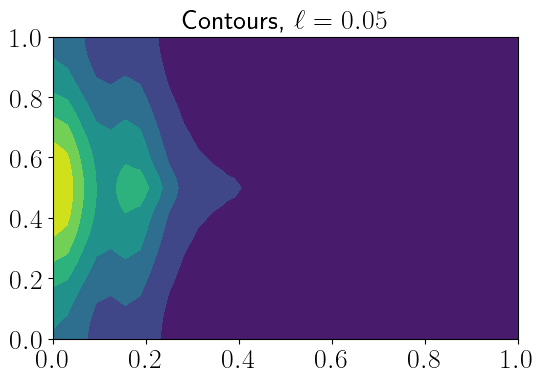

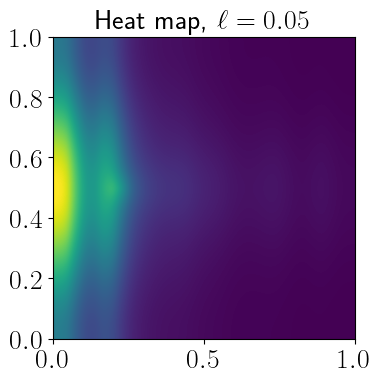

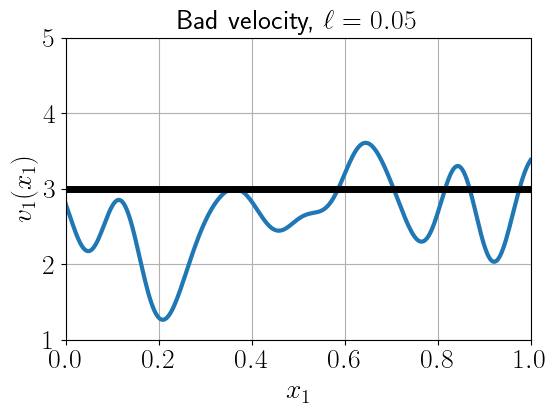

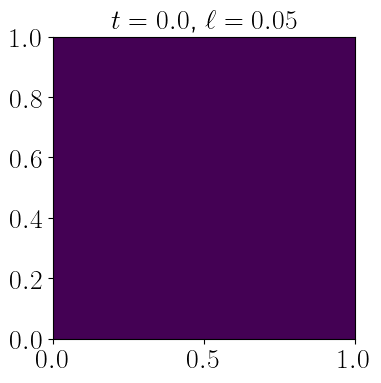

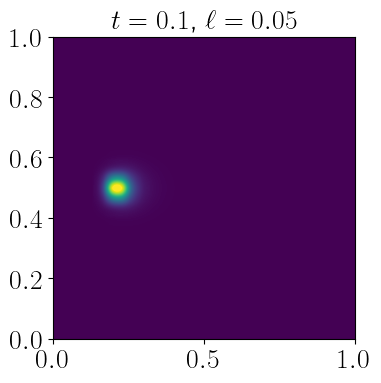

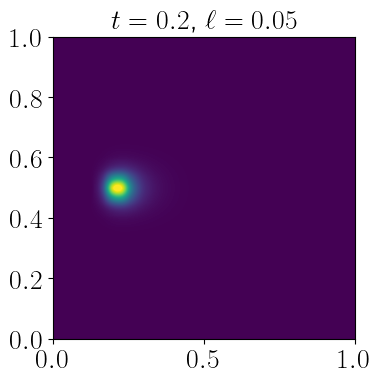

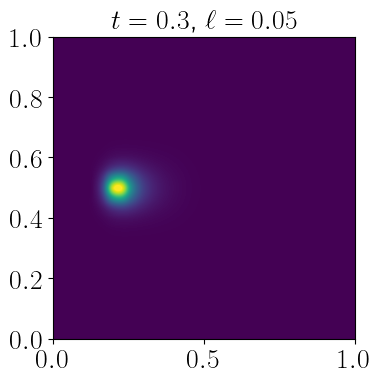

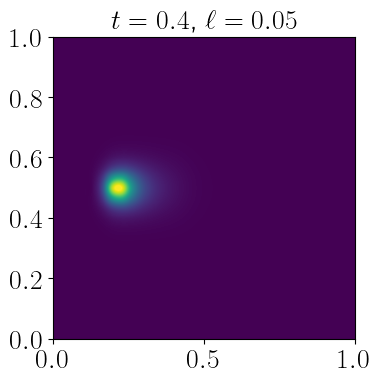

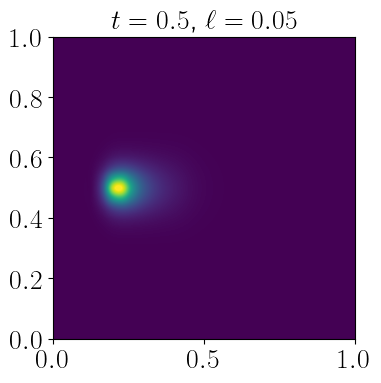

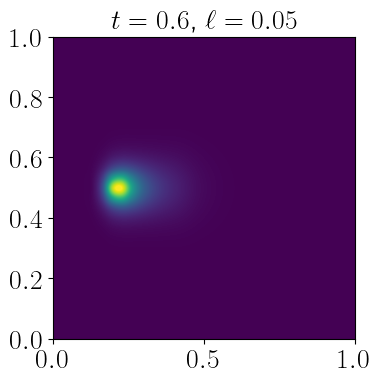

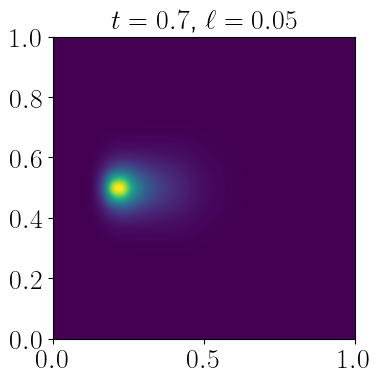

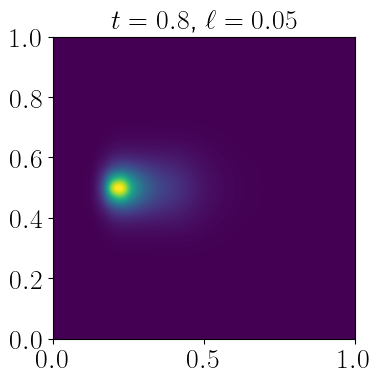

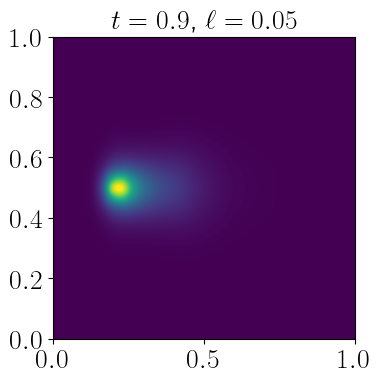

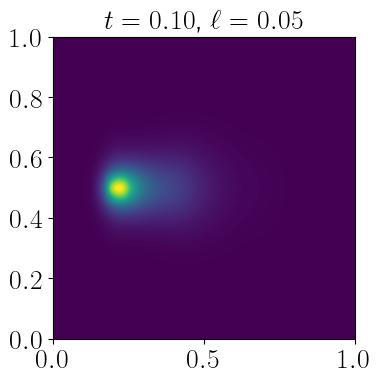

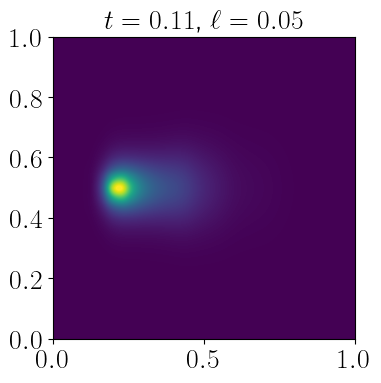

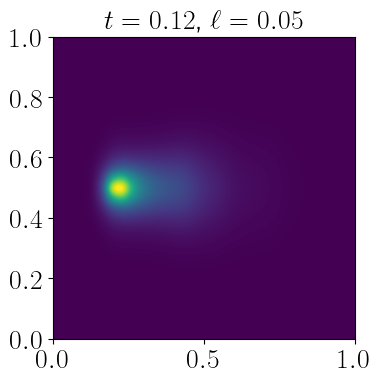

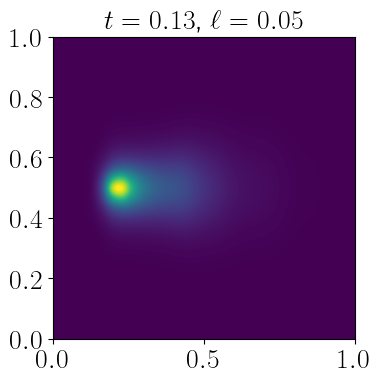

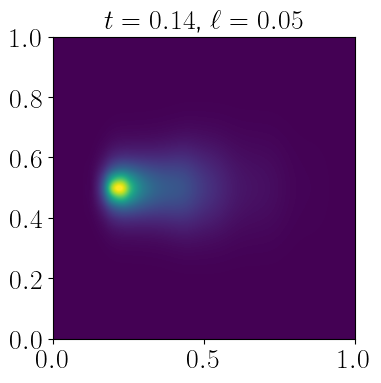

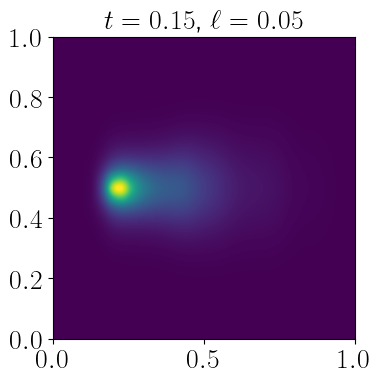

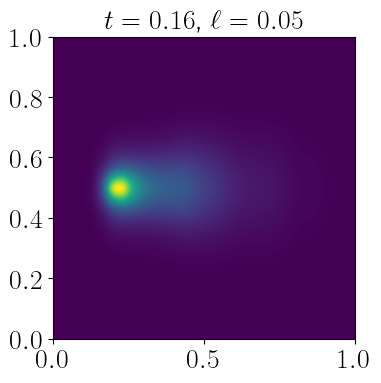

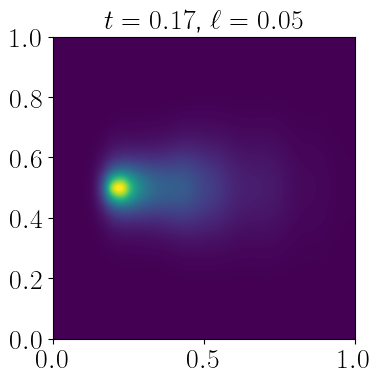

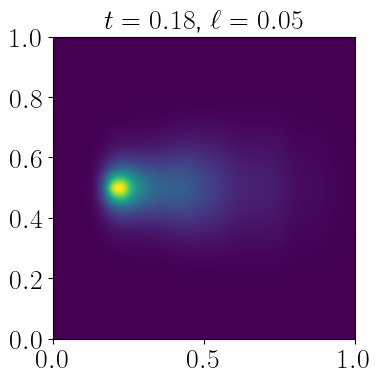

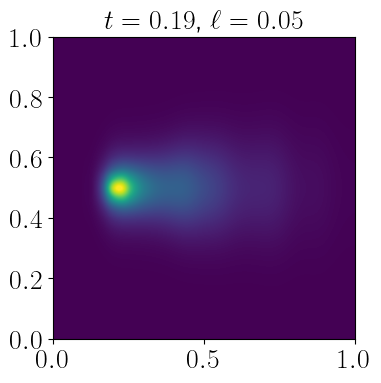

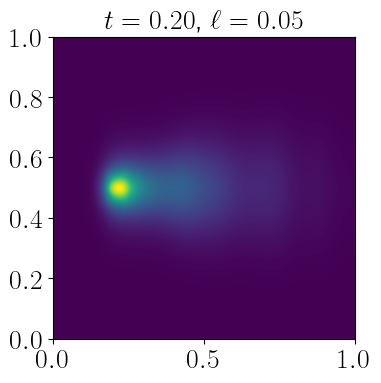

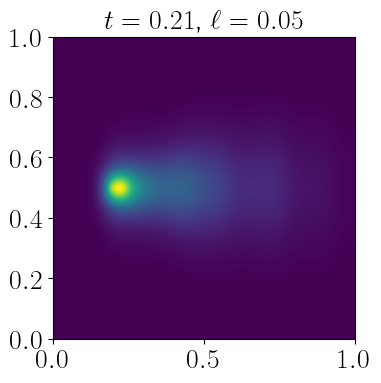

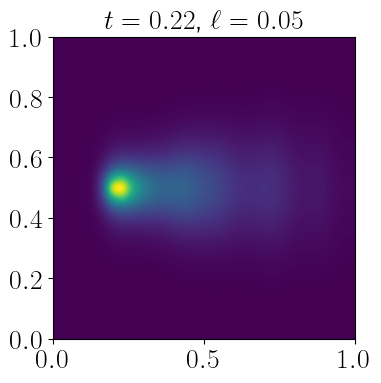

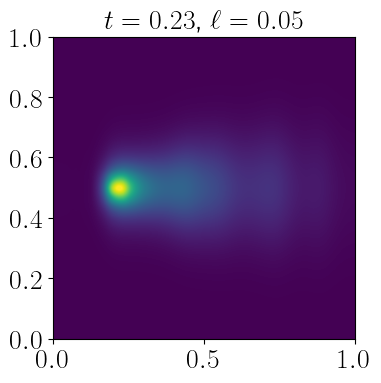

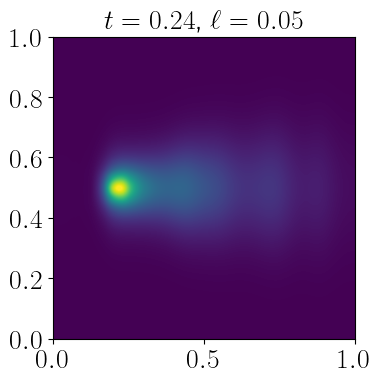

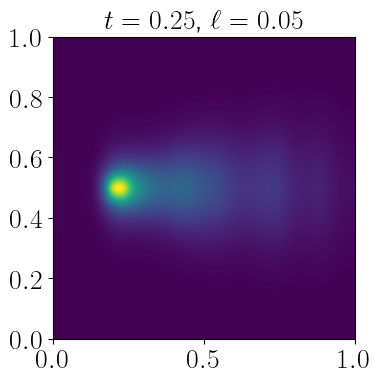

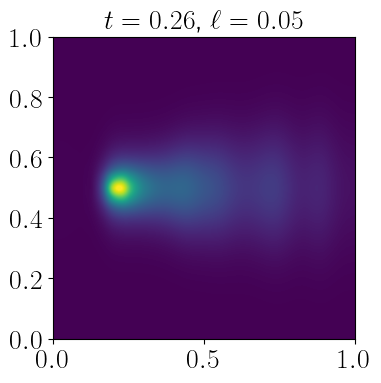

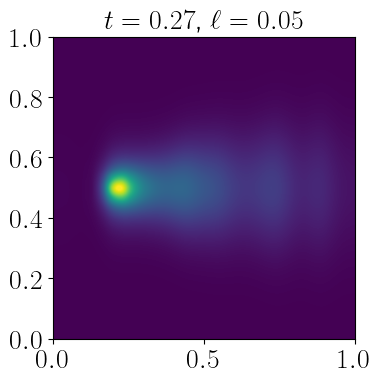

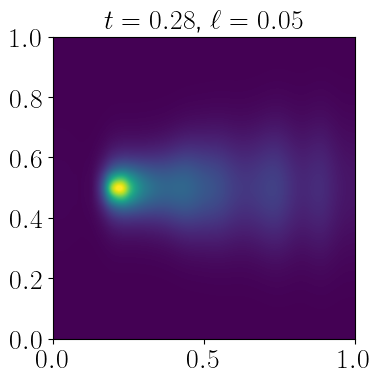

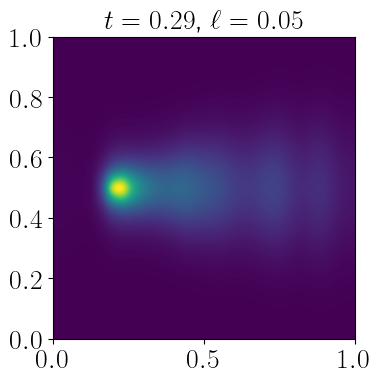

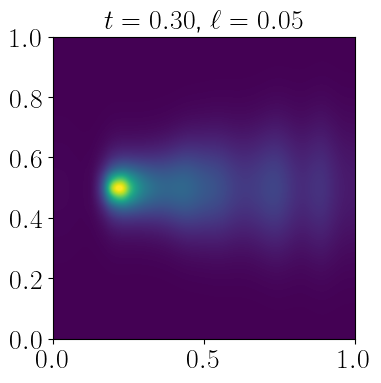

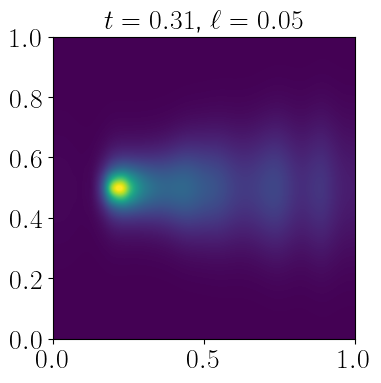

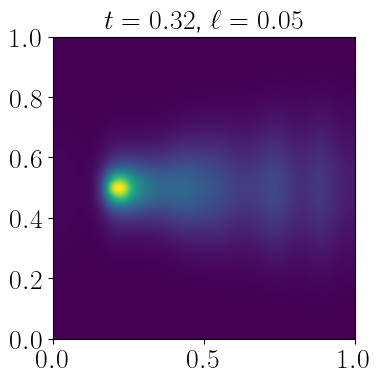

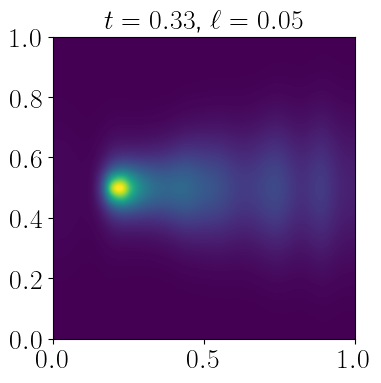

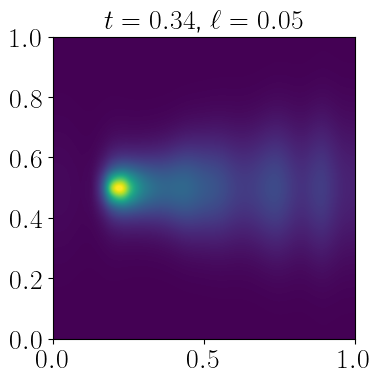

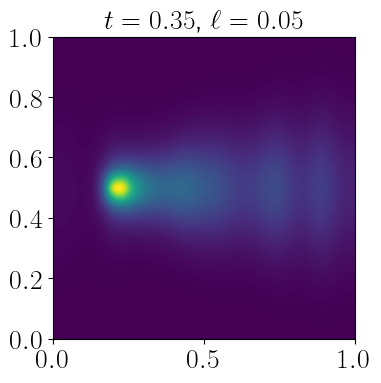

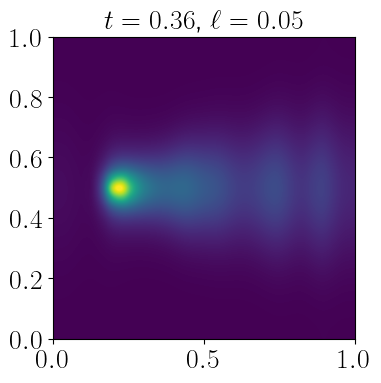

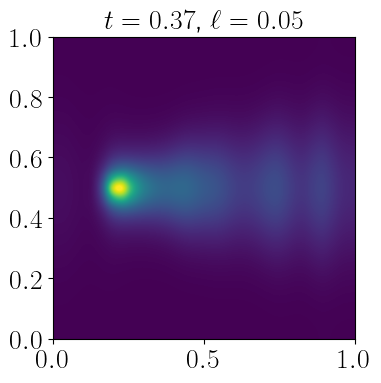

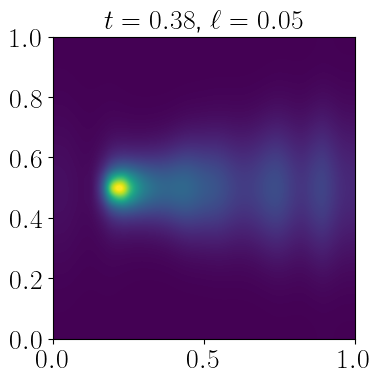

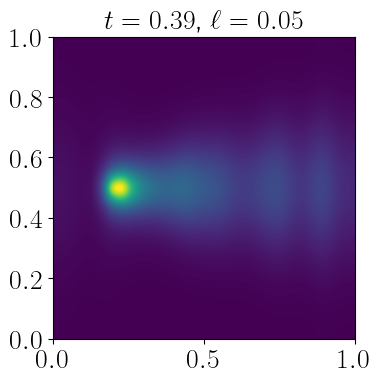

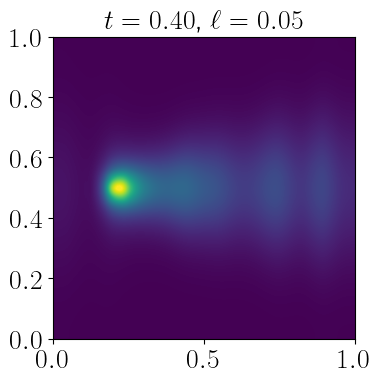

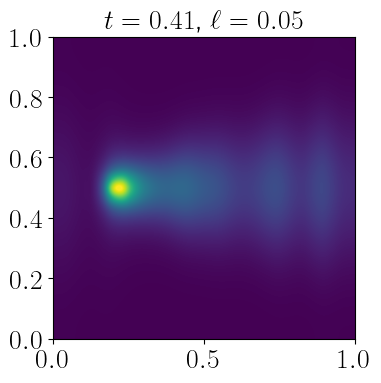

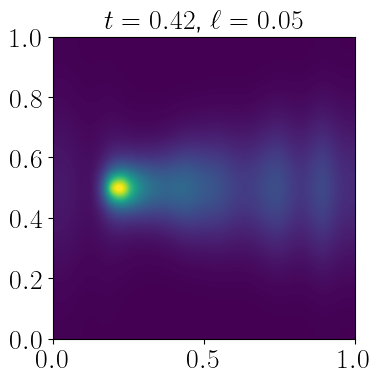

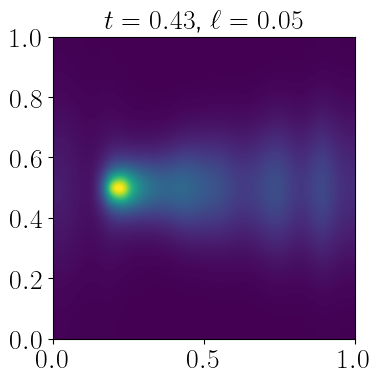

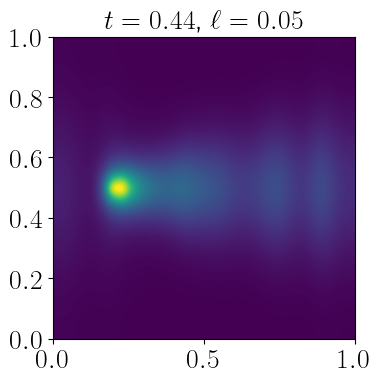

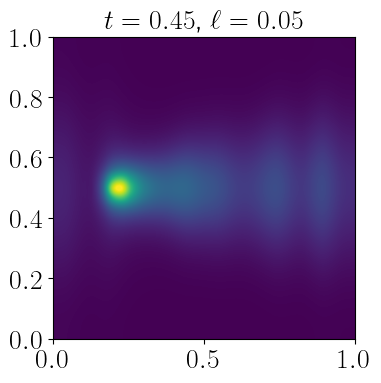

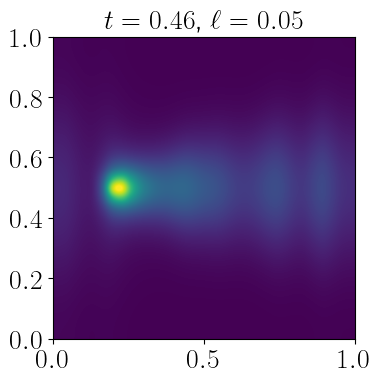

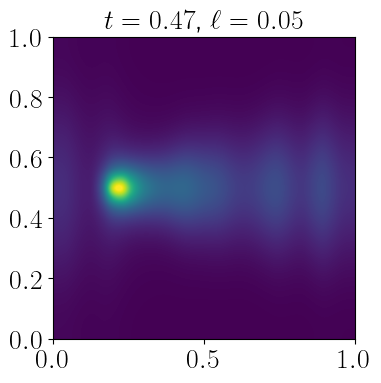

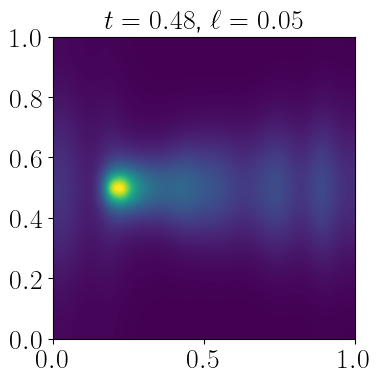

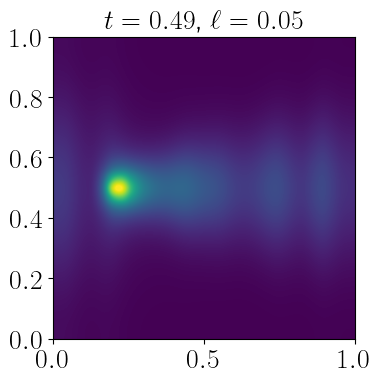

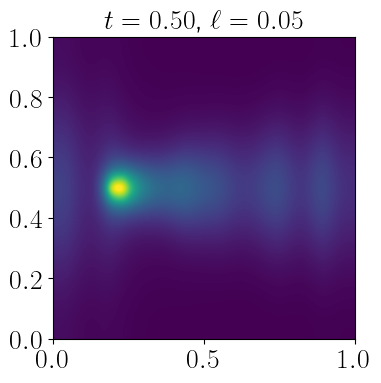

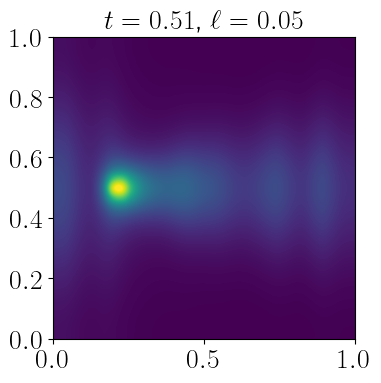

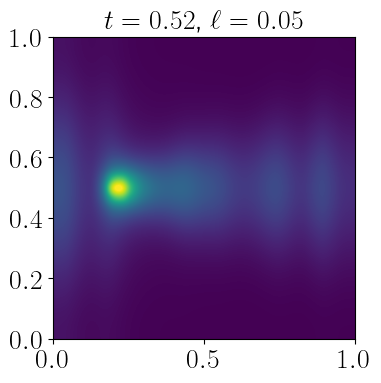

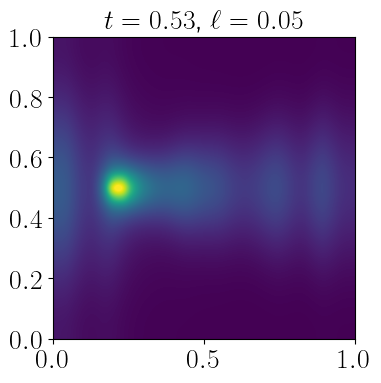

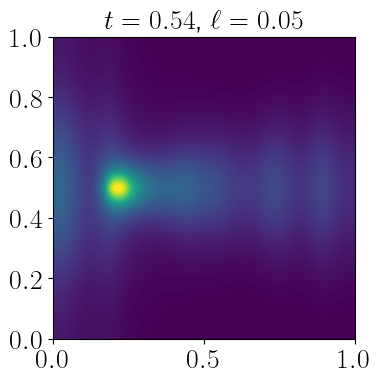

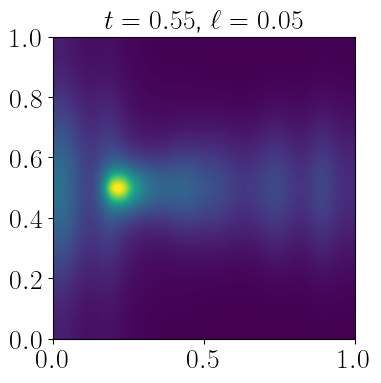

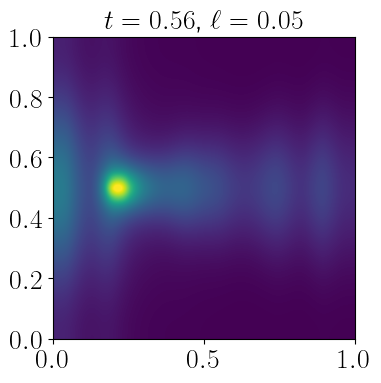

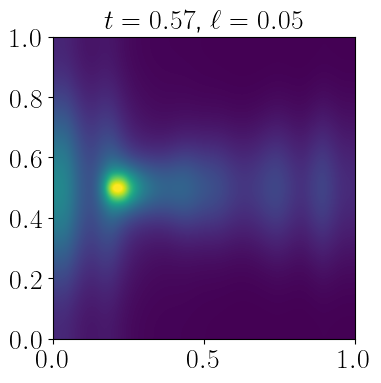

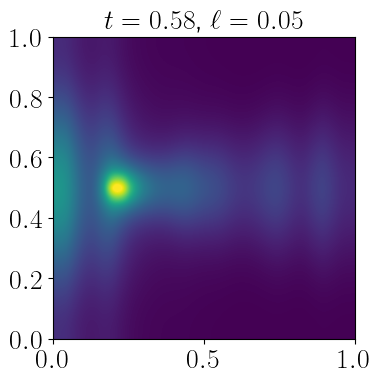

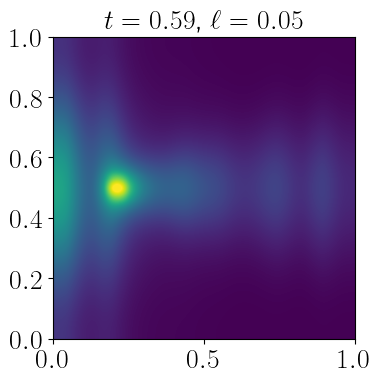

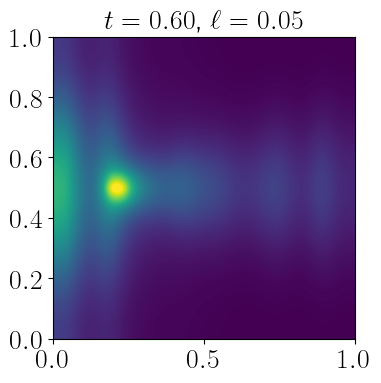

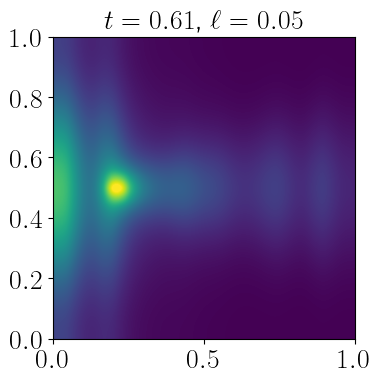

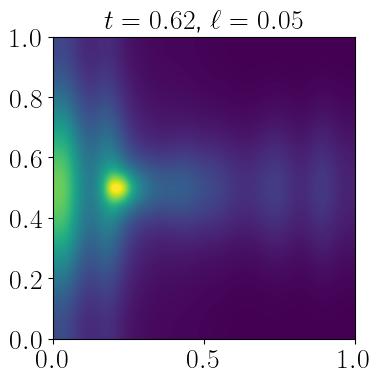

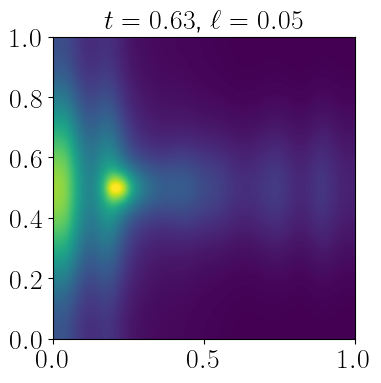

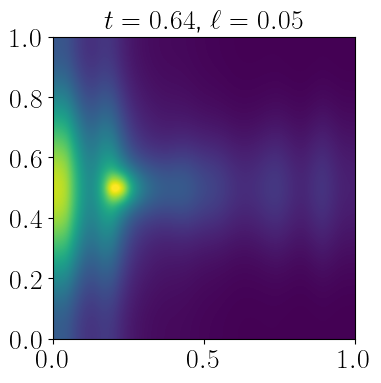

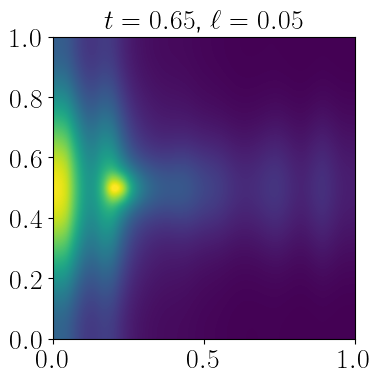

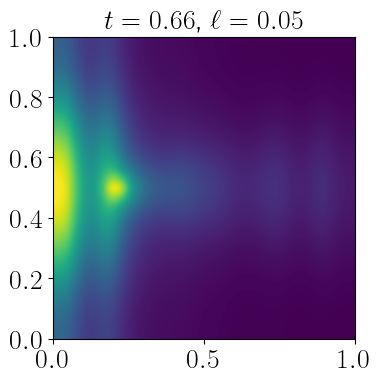

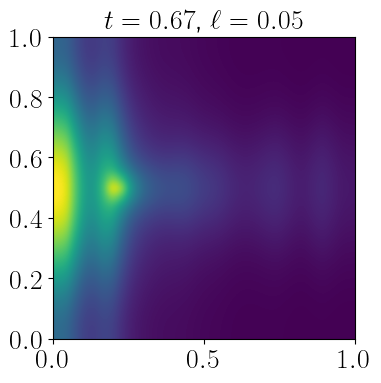

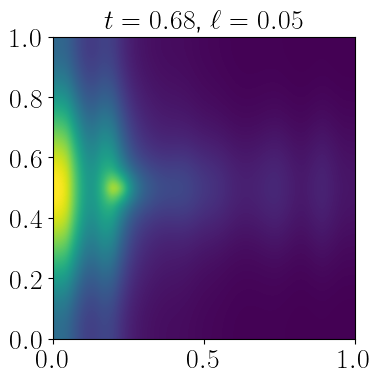

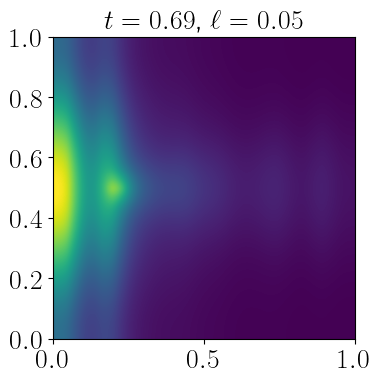

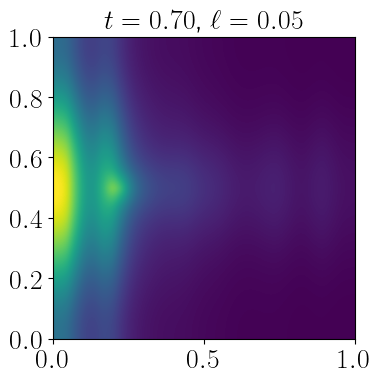

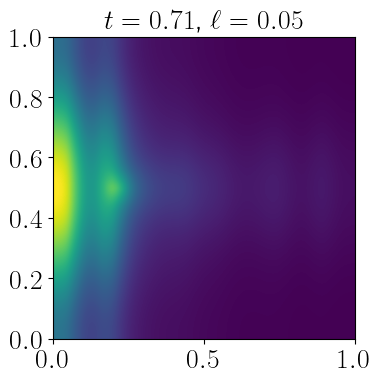

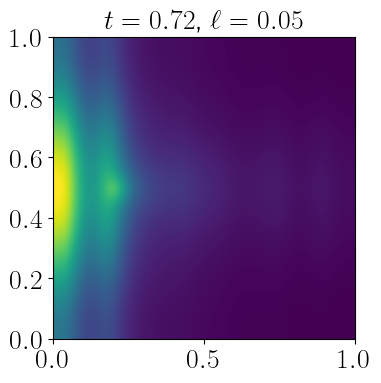

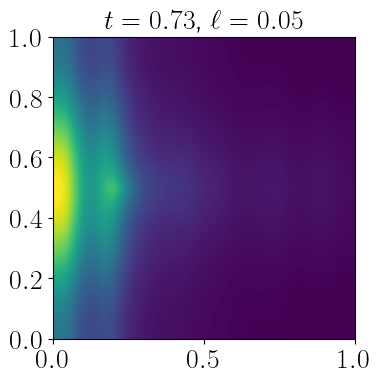

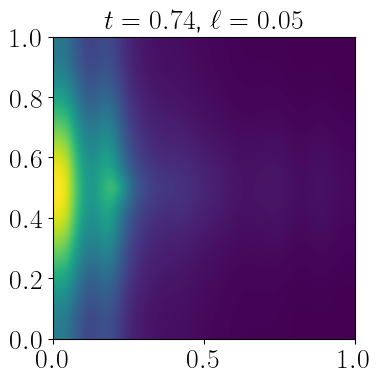

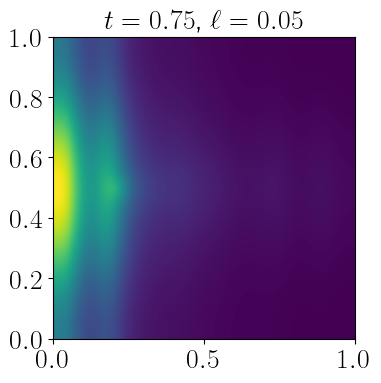

In [6]:
bad_xi = np.array([-8.97272167e-01, -7.70664934e-01, -8.67168524e-01,  8.33371415e-02,
       -2.83004908e-01,  2.59556530e-01,  6.30331253e-01,  2.29779637e-01,
       -9.67407314e-01, -3.31340764e-01, -5.25159093e-01, -8.97841379e-01,
        9.17689579e-01, -6.79939235e-01,  9.29892411e-01,  1.85840564e-01,
        9.79947577e-01,  3.48158886e-01, -1.06084522e-01,  5.81536019e-01,
        1.81319606e-01, -6.78892816e-01,  2.80433376e-01, -2.75548926e-03,
       -2.13878362e-01,  8.30242309e-01,  7.60105273e-01,  9.42614753e-01,
       -7.49768599e-01,  8.50960192e-01, -5.96788687e-01,  8.85148362e-01,
       -7.06623806e-02,  4.06559616e-01,  5.40210573e-01,  2.36633965e-01,
        2.17157044e-02, -8.90489679e-01, -6.76331564e-01,  4.89389049e-01,
       -2.76881823e-01, -8.53969121e-04, -2.60407945e-01,  8.63045012e-01,
        1.37713845e-01, -8.09537602e-01, -6.77508490e-01, -7.87238255e-01,
       -1.18495701e-01, -9.18189934e-01, -6.08571193e-01, -5.95883789e-01,
        8.86253598e-01, -3.50324546e-01, -7.23326920e-01, -6.86265851e-01,
       -7.81202244e-01,  8.16508412e-01,  9.87615556e-01, -1.33582228e-02,
        1.25785853e-01, -8.05041668e-01, -8.90169971e-01, -9.11907767e-01,
        2.74319025e-01, -2.59955271e-01,  9.48213066e-01, -1.69654653e-01,
        5.06839197e-01,  7.48323562e-01,  4.25279440e-01,  9.29576719e-01,
       -6.84410015e-01,  9.34641600e-01, -3.49712266e-01,  5.89865135e-01,
       -2.22907843e-01, -5.54411122e-01,  2.29033478e-01, -2.82986568e-01,
        3.09043214e-01, -4.79670411e-01,  1.71457877e-01,  3.47798057e-01,
        1.09923964e-01,  4.22464118e-01,  5.38899535e-01, -3.94185186e-01,
       -3.39488772e-01,  5.35337881e-01,  8.83605047e-02,  5.14542778e-02,
        2.90384394e-01,  8.12456097e-01, -8.92466209e-01, -5.81767062e-01,
       -1.17006313e-01,  9.57877989e-01,  8.47224737e-01, -7.11262245e-01])

d = 20
ell = 0.05 # strange behavior near 0.05
num_partitions = 32 # still happens with 64 or 128
nx_kl = 301

bad_xi = bad_xi[:d]
(X, Y) = np.meshgrid(np.linspace(0,1,num_partitions+1), np.linspace(0,1,num_partitions+1))
u = AdvecDiff2D(xi=bad_xi, store_snapshots=True, num_partitions=num_partitions, ell=ell, dt=0.01, nx_kl=nx_kl)
print("QoI is:", u.qoi, "(This is large, and it gets even larger as d increases)")
u_plot = np.reshape(u.snapshots[-1,:], (num_partitions+1, num_partitions+1))
plt.contourf(X,Y, u_plot) #,vmin=0, vmax=15)
plt.title(r'Contours, $\ell=%3.2f$' % ell)
plt.show()

plt.imshow(u_plot, origin="lower", interpolation="spline16", extent=(0, 1, 0, 1))
plt.title(r'Heat map, $\ell=%3.2f$' % ell)
plt.show()

nx_mesh = nx_kl
bkl = kle.MeshKLE(mesh_coords=np.linspace(0,1,nx_mesh)[None, :], mean_field=3, matern_nu=np.inf)
bkl.matern = bkl.matern_nu
bkl.compute_basis(ell, sigma=1, nterms=bad_xi.shape[0])
bad_vel = bkl(bad_xi[:,None]).ravel()
plt.plot(np.linspace(0,1,nx_mesh), bad_vel)
plt.plot(np.linspace(0,1,nx_mesh), 3*np.ones(bad_vel.shape), 'k',linewidth=5)
plt.grid()
plt.xlim(0,1)
plt.ylim(3-2,3+2)
plt.xlabel(r'$x_1$')
plt.ylabel(r'$v_1(x_1)$')
plt.title(r'Bad velocity, $\ell=%3.2f$' % ell)
plt.show()

for i, state in enumerate(u.snapshots):
    plt.imshow(np.reshape(state, (num_partitions+1, num_partitions+1)), origin="lower", interpolation="spline16", extent=(0, 1, 0, 1))
    plt.title(r'$t=0.%d$, $\ell=%3.2f$' % (i, ell))
    plt.show()

## Karhunen&ndash;Lo&#232;ve (KL) modes <a id='residual_energy'></a>

Let's examine the first several KL modes and see the effect on the concentration $u$. Here we define the residual energy (uncaptured variance) as
$$
\mathcal{E}_k = 1 - \frac{\sum_{j=1}^k \lambda_j}{\sum_{j=1}^\infty \lambda_j} .
$$

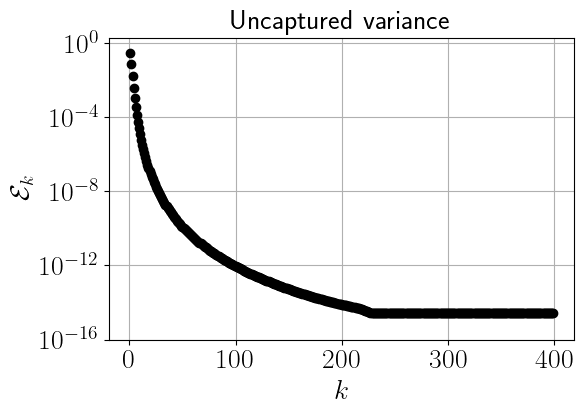

In [5]:
#nu = np.inf
nu = 1.5
d = 5
l_plot = 0.25 # 0.25
xnum_plot = 4096 + 1 # 101
knum_plot = 400 # 16

velocity_kle = kle.MeshKLE(mesh_coords=np.linspace(0,1,xnum_plot)[None, :], mean_field=3, matern_nu=nu)
velocity_kle.matern = velocity_kle.matern_nu # there is a bug typo in the source code!

K = velocity_kle.compute_kernel_matrix(l_plot)
lam, V = np.linalg.eig(K)

plt.semilogy(np.arange(1,knum_plot), 1-np.cumsum(lam[:knum_plot-1]**2)/np.sum(lam**2), 'ko')
plt.grid()
plt.xlabel(r'$k$')
plt.ylabel(r'$\mathcal{E}_k$')
plt.title('Uncaptured variance')
plt.ylim([1e-16, 2e0])

if save_plots:
    plt.savefig('manuscript/figs/KL_variance.pdf', format='pdf')

plt.show()

From these plots, especially the residual energy plot, we can see that the first few modes capture most of the variance.

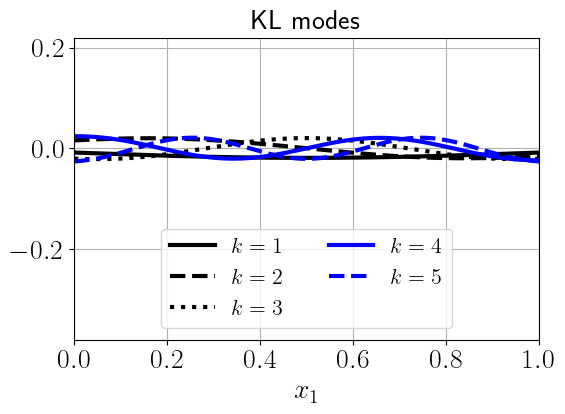

In [6]:
style_list = ['k', 'k--', 'k:', 'b', 'b--']
for i in range(d):
    plt.plot(np.linspace(0,1,xnum_plot), V[:,i], style_list[i], label=r'$k=%d$' % (i+1))
plt.grid()
plt.xlabel(r'$x_1$')
plt.ylim(-0.38, 0.22)
plt.legend(ncol=2, loc='lower center')
plt.title(r'KL modes')
plt.xlim(0, 1)
if save_plots:
    plt.savefig('manuscript/figs/KL_modes.pdf', format='pdf')
plt.show()

Convection will be faster when the velocity is larger in magnitude. As a result, roughly speaking, we would expect the QoI to be lower when the parameters emphasize KL modes with smaller (or negative) regions for $x_1 < 0.5$, and vice versa for $x_1 > 0.5$.

## Velocity field realizations

Here are 100 realizations of the velocity field with $N_{\text{KLE}} = 5$ KL modes.

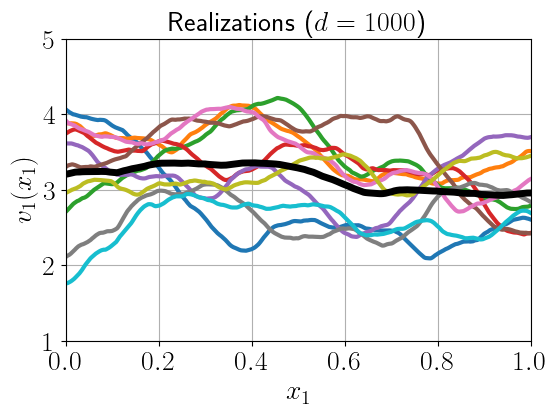

In [12]:
N_realizations = 10 # 100
d = 1000 # 5
xi = np.random.uniform(-1,1,(N_realizations,d)) # subgaussian measure bounded almost surely
velocity_kle.compute_basis(l_plot, sigma=1, nterms=d)
avg = 0
for realization in xi:
    output = velocity_kle(realization[:,np.newaxis])
    avg += output
    plt.plot(np.linspace(0,1,xnum_plot), output)

avg /= N_realizations
plt.plot(np.linspace(0,1,xnum_plot), avg, 'k',linewidth=5)
plt.grid()
plt.ylim(1,5)
plt.xlim(0,1)
plt.xlabel(r'$x_1$')
plt.ylabel(r'$v_1(x_1)$')
plt.title(r'Realizations ($d=%d$)' % d)

if save_plots:
    plt.savefig('manuscript/figs/KL_realizations.pdf', format='pdf')
    
plt.show()

## Example concentration surfaces

Below are plots of the final-time solution $u$ for various two-dimensional parameter choices $\mathbf{\xi}$. All plots use the same color scale.

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


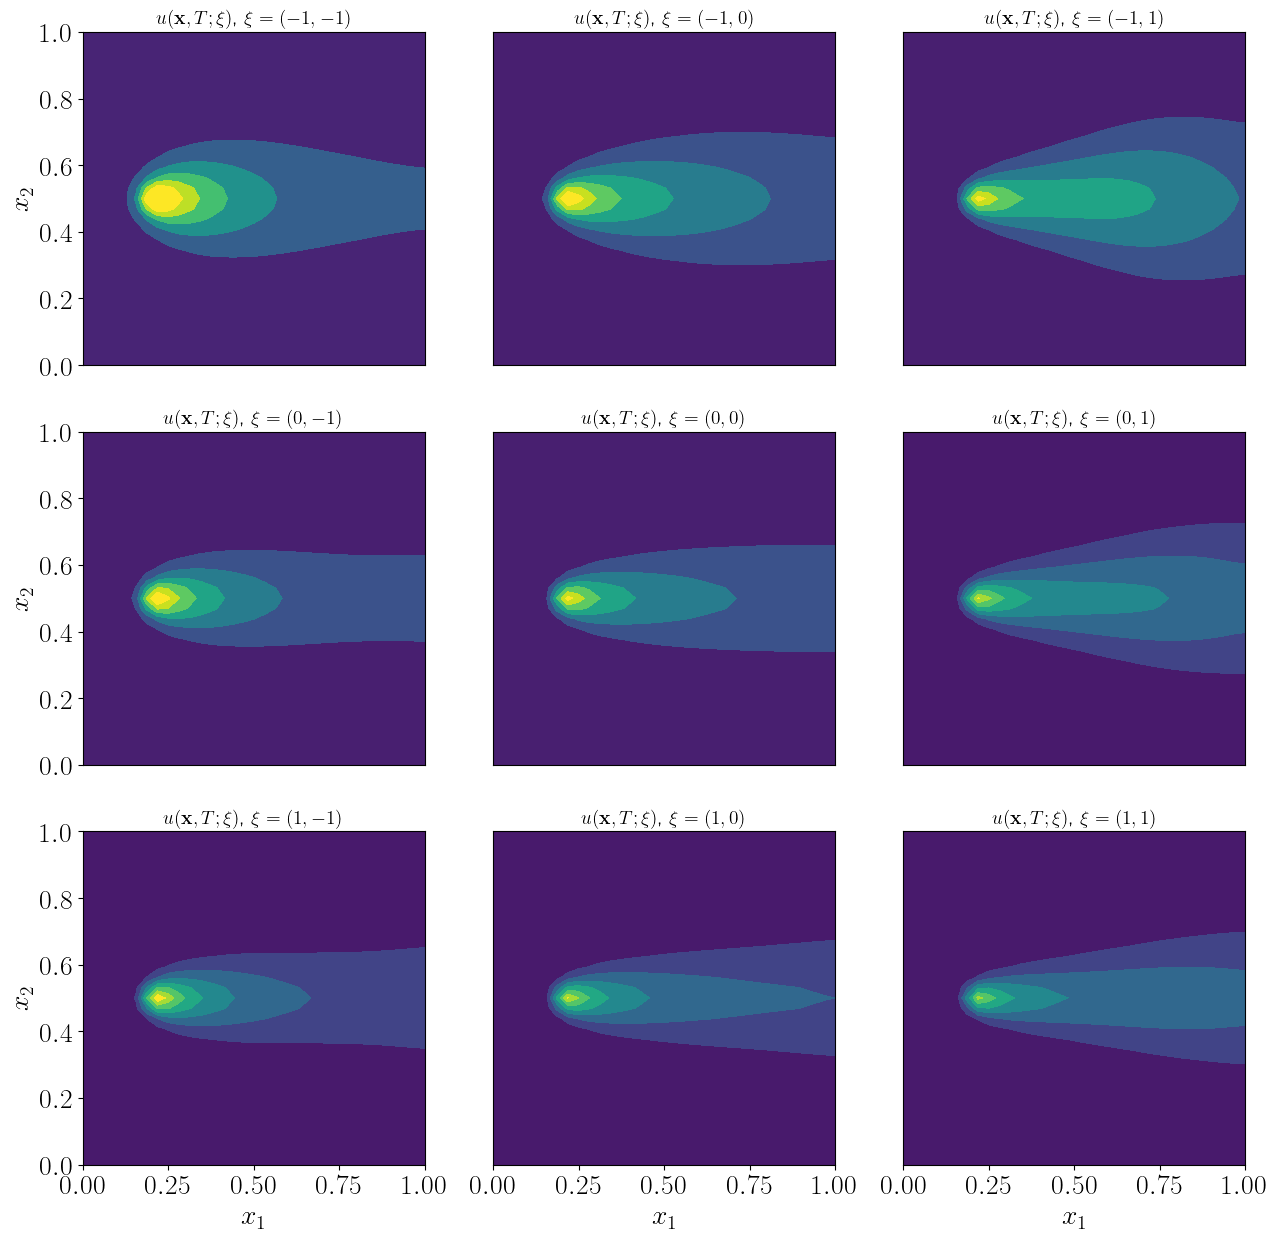

In [63]:
fig, ax = plt.subplots(3,3)
fig.set_size_inches(15,15)
num_partitions = 32
(X, Y) = np.meshgrid(np.linspace(0,1,num_partitions+1), np.linspace(0,1,num_partitions+1))
for i in range(3):
    for j in range(3):
        u = AdvecDiff2D(xi=[i-1, j-1], store_snapshots=True, num_partitions=num_partitions)
        ax[i,j].contourf(X,Y, np.reshape(u.snapshots[-1,:], (num_partitions+1, num_partitions+1)),
                        vmin=0, vmax=15)
        ax[i,j].set_title(r'$u(\mathbf{x}, T; \mathbf{\xi})$, $\mathbf{\xi} = (%d, %d)$' % (i-1,j-1), fontsize=14)
        if i == 2:
            ax[i,j].set_xlabel(r'$x_1$')
        else:
            ax[i,j].axes.xaxis.set_visible(False)
        if j == 0:
            ax[i,j].set_ylabel(r'$x_2$')
        else:
            ax[i,j].axes.yaxis.set_visible(False)

            
if save_plots:
    plt.savefig('manuscript/figs/concentration_example.pdf', format='pdf')
    
plt.show()

## Example QoI surface

Now we show the QoI as a function (called the *response function*) of two parameters, each drawn from $[-1,1]$.

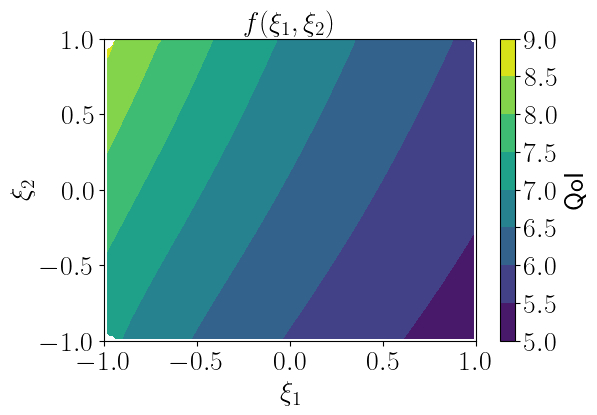

In [76]:
# num_partitions = 32
# (X, Y) = np.meshgrid(np.linspace(-1,1,num_partitions+1), np.linspace(-1,1,num_partitions+1))
# qoi = np.loadtxt(os.path.join(data_folder, 'training/efficiency/32/qoi.txt'))

# plt.contourf(X, Y, np.reshape(qoi, (num_partitions+1, num_partitions+1)), cmap=cm.viridis)
# plt.title(r'$f(\xi_1, \xi_2)$')
# plt.xlabel(r'$\xi_1$')
# plt.ylabel(r'$\xi_2$')
# plt.colorbar(label=r'QoI')

# if save_plots:
#     plt.savefig('manuscript/figs/qoi_example.pdf', format='pdf')
    
# plt.show()

# From test dataset with d=2
num_partitions = 128
(X, Y) = np.meshgrid(np.linspace(-1,1,num_partitions+1), np.linspace(-1,1,num_partitions+1))
q_pts = np.array((X.flatten(), Y.flatten())).T
qoi = np.loadtxt(os.path.join(data_folder, '2d/qoi.txt'))
params = np.loadtxt(os.path.join(data_folder, '2d/params.txt'))
qoi_interp = scipy.interpolate.griddata(params, qoi, q_pts)
qoi_interp = np.reshape(qoi_interp, (num_partitions+1, num_partitions+1))
plt.contourf(X, Y, qoi_interp, cmap=cm.viridis)
plt.title(r'$f(\xi_1, \xi_2)$')
plt.xlabel(r'$\xi_1$')
plt.ylabel(r'$\xi_2$')
plt.colorbar(label=r'QoI')

if save_plots:
    plt.savefig('manuscript/figs/qoi_example.pdf', format='pdf')
    
plt.show()



# Approximation Methods <a id='approximation_methods'></a>

In this section, we will apply various function and operator approximation methods to the 2D advection-diffusion system, with the goal of approximating the parameter-to-QoI map. Standard metrics for robustness, scalability, and efficiency are used for characterization. We adopt the following notation unless explicitly stated otherwise:

* $\sigma$ is the standard deviation of mean-zero, normally distributed additive noise
* $d$ refers to the dimension of the parameter space, i.e. $\mathbf{\xi} \in [-1,1]^d$
* $N$ is the number of training samples

But first, let's define some helper code for computing approximation accuracy.

In [77]:
def validate(f, fhat):
    '''
    Helper function to compute relative L^2 error of approximations.
    Takes care of different array shape interpretations in numpy.
    
    INPUTS:
            f : array of high-fidelity function values
         fhat : array of approximation values
        
    OUTPUTS:
        error : float, relative error
    '''
    f, fhat = np.asarray(f).flatten(), np.asarray(fhat).flatten()
    return np.linalg.norm(f-fhat) / np.linalg.norm(f)

# Function Approximation

This section focuses specifically on function approximation methods: Gaussian processes, sparse grids, polynomial fitting (especially polynomial chaos expansion), and wavelet compression.

In [78]:
def parameter_to_qoi(xi):
    vals = [AdvecDiff2D(param).qoi for param in xi]
    return np.asarray(vals)[:,np.newaxis]

In [82]:
def RISE(method, d=2, N=1024, sigma=0.0, **kwargs):
    '''
    Computes relative L^2 accuracy of approximation for various 
    dimensions, noise levels, and number of training data.
    
    INPUTS:
               method : function with signature (f, d, N, sigma) -> approx, where
                {      f : function handle f(x), where x is (Nx, d) array 
                {          and f(x) is (Nx, 1) array
                {      d : int, dimension of input
                {      N : int, number of training samples
                {  sigma : float, additive noise to f(x)
                { approx : function handle approx(x), where x is (Nx, d)
                {          array and approx(x) is (Nx, 1) array
                    d : int or arraylike, dimensions
                    N : int or arraylike, number of training data
                sigma : int or arraylike, additive noise level
        return_approx : bool, whether to return the last computed approximation
                        (useful for plotting), default False
    
    OUTPUTS:
             accuracy : array of L^2 accuracy along non-singleton
                        input of (d, N, sigma)
                  obj : approximation object at final iteration, 
                        useful for plotting (optional)
    '''
    
    accuracy = []
    
    return_obj = kwargs['return_obj'] if 'return_obj' in kwargs.keys() else False
    
    
    # convert non-iterable inputs to iterables (for ease of for-loop programming)
    d = np.asarray(d).flatten()
    sigma = np.asarray(sigma).flatten()
    N = np.asarray(N).flatten()
    
    # sanity check on inputs
    held_constant = np.sum([arr.size == 1 for arr in [d, sigma, N]])
    if held_constant < 2:
        raise ValueError('At most one of d, sigma, and N may be non-singleton')
    
    for d_i in d:
        validation_samples = np.atleast_2d(np.loadtxt(os.path.join(data_folder, 
                                            'validation/%dd/params.txt' % d_i)))
        if d_i == 1:
            validation_samples = validation_samples.T
        validation_values = np.loadtxt(os.path.join(data_folder, 
                                            'validation/%dd/qoi.txt' % d_i))
        for N_i in N:
            for sigma_i in sigma:
                obj, approx = method(f=lambda x: parameter_to_qoi(x), 
                                d=d_i, N=N_i, sigma=sigma_i, **kwargs)
                accuracy.append(validate(validation_values, approx(validation_samples)))
                if 'pce_wrapper' in method.__name__:
                    os.remove(os.path.join(scratch_folder, 'pce_training_samples.txt'))
                    os.remove(os.path.join(scratch_folder, 'pce_training_values.txt'))

    return (np.asarray(accuracy), obj) if return_obj else np.asarray(accuracy)

## Gaussian Processes (GPs)

In [83]:
def adaptive_gp_wrapper(f, d, N, sigma, **kwargs):
    '''
    Wrapper for Gaussian Process method.
    
    INPUTS:
        f      : function handle f(x), where x is (Nx, d) array 
                 and f(x) is (Nx, 1) array
        d      : int, dimension of input
        N      : int, number of training samples
        sigma  : float, additive noise to f(x)
    
    OUTPUTS:
           obj : approximation object, useful for plotting
        approx : function handle approx(x), where x is (Nx, d)
                 array and approx(x) is (Nx, 1) array
    '''
    
    verbose = kwargs['verbose'] if 'verbose' in kwargs.keys() else False
    
    obj = pya.surrogates.adaptive_approximate(lambda x : f(x.T) + np.random.normal(0, sigma, (np.asarray(x).shape[1],1)), 
                                      [scipy.stats.uniform(-1,2)]*d,
                                      'gaussian_process', 
                                      {'nu': np.inf,
                                       'length_scale_bounds': (1e-3, 5e-1),
                                       'length_scale': 0.25,
                                       'max_nsamples': N,
                                       'weight_function': lambda x: np.ones(np.asarray(x).shape[1]),
                                       'ncandidate_samples': 1e3,
                                       'normalize_inputs': True,
                                       'checkpoints': np.linspace(1,N).astype(int),
                                       'verbose': verbose,
                                      })
    return (obj, lambda x: obj.approx(x.T))

### Example

Consider $N=6$ training samples with $d=1$ parameter and no noise. Let's plot the high-fidelity map, mean of GP approximation, and 25th-75th percentile of GP prediction.

In [84]:
_, output = RISE(adaptive_gp_wrapper, N=6, d=1, sigma=0, return_obj=True)

In [85]:
print(output)

plot_samples = np.linspace(-1,1,1024)[:,np.newaxis].T
plot_true = np.loadtxt(os.path.join(data_folder, 'training/scalability/1d/qoi.txt'))
plot_vals, plot_std = output.approx(plot_samples, return_std=True)
plt.plot(plot_samples.T, plot_true, 'k', label='High-fidelity')
plt.plot(plot_samples.T, plot_vals, 'k:', label='GP mean')
plt.plot(output.approx.X_train_, output.approx.y_train_, 'ko', markersize=5)

# plot 25-75 percentile gap 
# (z = 1.15 corresponds to 75% of normal distribution)
plt.fill_between(plot_samples.flatten(), plot_vals.flatten()-1.15*plot_std.flatten(),
                  plot_vals.flatten()+1.15*plot_std.flatten(), color='k', alpha=0.2)

plt.legend(loc='upper right')
plt.xlabel(r'$\xi_1$')
plt.ylabel(r'QoI')
plt.title(r'Gaussian Process ($N=6$)')
plt.grid()
if save_plots:
    plt.savefig('manuscript/figs/adaptive_GP_surrogate.pdf', format='pdf')
plt.show()

 approx: AdaptiveGaussianProcess(alpha=0, kernel=Matern(length_scale=0.25, nu=inf),
                        n_restarts_optimizer=1)


FileNotFoundError: ../data/training/scalability/1d/qoi.txt not found.

Now for plots of robustness, scalability, and efficiency. Up first: robustness.

### Robustness

In [86]:
# placement of samples is independent of noise; do adaptivity at front end
sigma_arr = np.arange(0,2.01,0.25)
_, output = RISE(adaptive_gp_wrapper, d=2, N=40, sigma=0, return_obj=True)

X_train = output.approx.X_train_
y_train = np.copy(output.approx.y_train_)
accuracy = []
d = 2
validation_samples = np.atleast_2d(np.loadtxt(os.path.join(data_folder, 
                                    'validation/%dd/params.txt' % d)))
validation_values = np.loadtxt(os.path.join(data_folder, 
                                    'validation/%dd/qoi.txt' % d))

for i in range(100):
    accuracy.append([])
    for sigma in sigma_arr:
        output.approx.fit(X_train.T, y_train + np.random.normal(0, sigma, y_train.shape))
        accuracy[-1].append(validate(validation_values, 
                                     output.approx.predict(validation_samples)))

accuracy = np.asarray(accuracy)

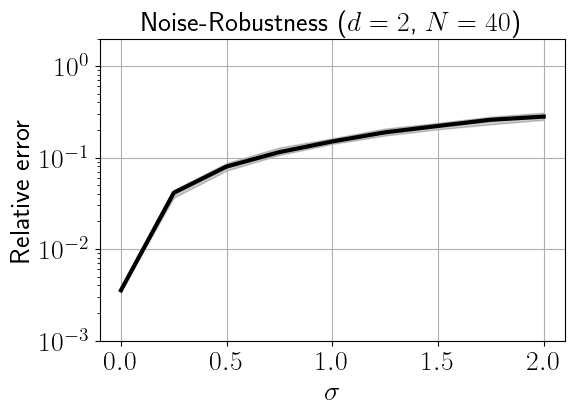

In [87]:
lb = np.percentile(accuracy, 25, axis=0)
med = np.percentile(accuracy, 50, axis=0)
ub = np.percentile(accuracy, 75, axis=0)

plt.semilogy(sigma_arr, med, 'k')
plt.fill_between(sigma_arr, lb, ub, color='k', alpha=0.2)
plt.xlabel(r'$\sigma$')
plt.ylabel(r'Relative error')
plt.title(r'Noise-Robustness ($d=2$, $N=40$)')
plt.grid()
plt.ylim([1e-3, 2e0])
if save_plots:
    plt.savefig('manuscript/figs/adaptive_GP_R.pdf', format='pdf')
plt.show()

### Scalability

In [ ]:
d_arr = [1,2,5,10,15,20]
gp_s = RISE(adaptive_gp_wrapper, d=d_arr, N=40, sigma=0)

In [ ]:
plt.semilogy(d_arr[1:], gp_s[1:], 'k')
plt.xlabel(r'$d$')
plt.ylabel(r'Relative error')
plt.title(r'Scalability ($N=40$, $\sigma=0$)')
plt.grid()
plt.ylim([1e-3, 2e0])
if save_plots:
    plt.savefig('manuscript/figs/adaptive_GP_S.pdf', format='pdf')
plt.show()

### Efficiency

In [ ]:
# Adaptive GP samples
N_arr = np.hstack((5, np.arange(10,51,10)))
gp_e_adaptive = RISE(adaptive_gp_wrapper, d=2, N=N_arr, sigma=0)

In [ ]:
# Uniformly distributed samples
shuffle_samples = np.loadtxt(os.path.join(data_folder, 'training/efficiency/shuffle/params.txt'))
shuffle_values = np.loadtxt(os.path.join(data_folder, 'training/efficiency/shuffle/qoi.txt'))

def uniform_gp_wrapper(f, d, N, sigma, **kwargs):
    
    verbose = kwargs['verbose'] if 'verbose' in kwargs.keys() else False
    i = kwargs['i']
    kernel = pya.surrogates.gaussianprocess.Matern(nu=np.inf, 
                                                   length_scale_bounds=(1e-3, 5e-1), 
                                                   length_scale=0.25)
    gp = pya.surrogates.gaussianprocess.GaussianProcess(kernel=kernel)
    gp.fit(shuffle_samples[i*N:(i+1)*N,:].T, shuffle_values[i*N:(i+1)*N,np.newaxis])
    return (gp, lambda x: gp(x.T))

gp_e_uniform = []
for i in range(100):
    gp_e_uniform.append(RISE(uniform_gp_wrapper, d=2, N=N_arr, sigma=0, i=i))
gp_e_uniform = np.asarray(gp_e_uniform)

In [ ]:
med = np.percentile(gp_e_uniform, 50, axis=0)
lb = np.percentile(gp_e_uniform, 25, axis=0)
ub = np.percentile(gp_e_uniform, 75, axis=0)
plt.semilogy(N_arr, gp_e_adaptive, 'k', label='Adaptive sampling')
plt.semilogy(N_arr, med, 'k:', label='Uniform sampling')
plt.fill_between(N_arr, lb, ub, color='k', alpha=0.2)
plt.legend(loc='upper right')
plt.xlabel(r'$N$')
plt.ylabel(r'Relative error')
plt.title(r'Efficiency ($d=2$, $\sigma=0$)')
plt.grid()
plt.ylim([1e-3, 2e0])
if save_plots:
    plt.savefig('manuscript/figs/adaptive_GP_E.pdf', format='pdf')
plt.show()

## Sparse Grids

In [ ]:
def adaptive_sg_wrapper(f, d, N, sigma, **kwargs):
    grid = tsg.SparseGrid()
    local = kwargs['local'] if 'local' in kwargs.keys() else True
    verbose = kwargs['verbose'] if 'verbose' in kwargs.keys() else False
    if local:
        grid.makeLocalPolynomialGrid(d,1,0,1,'localp')
    else:
        grid.makeGlobalGrid(d,1,1,'level','rleja')
        
    grid.setDomainTransform(np.tile([-1,1], (d,1)))
    points = grid.getNeededPoints()
    num_evals = grid.getNumPoints()
    tol = 0.99
    strategy = 'classic'
    
    while num_evals <= N:
        if verbose:
            print('Function evals: %d/%d' % (num_evals, N))
        values = f(points)
        values += np.random.normal(0, sigma, values.shape)
        grid.loadNeededPoints(values)

        if local: 
            grid.setSurplusRefinement(tol, -1, strategy)
        else:
            grid.setSurplusRefinement(tol, -1)
        points = grid.getNeededPoints()
        while points.size == 0:
            tol *= 0.99
            if local: 
                grid.setSurplusRefinement(tol, -1, strategy)
            else:
                grid.setSurplusRefinement(tol, -1)
            points = grid.getNeededPoints()
        num_evals += points.shape[0]

    return (grid, lambda x: grid.evaluateBatch(x))

### Example

In [ ]:
N_sg_example = 20
_, grid = RISE(adaptive_sg_wrapper, N=N_sg_example, d=2, sigma=0,
               return_obj=True, verbose=True)

In [ ]:
(X, Y) = np.meshgrid(np.linspace(-1,1,32), np.linspace(-1,1,32))
plot_samples = np.vstack((X.flatten(), Y.flatten())).T
points = grid.getPoints()
plot_true = np.loadtxt(os.path.join(data_folder, 'training/scalability/2d/qoi.txt'))
plt.contourf(X, Y, np.reshape(grid.evaluateBatch(plot_samples), X.shape), colorbar=cm.viridis)
plt.plot(points[:,0], points[:,1], 'ko')
plt.xlabel(r'$\xi_1$')
plt.ylabel(r'$\xi_2$')
plt.colorbar(label=r'QoI')
plt.title(r'Sparse Grid ($N=%d$)' % N_sg_example)
plt.grid()
if save_plots:
    plt.savefig('manuscript/figs/local_adaptive_SG_surrogate.pdf', format='pdf')
plt.show()

### Robustness

In [ ]:
sigma_arr = np.arange(0.0, 2.01, 0.25)
sg_r = RISE(adaptive_sg_wrapper, d=2, N=40, sigma=sigma_arr)

In [ ]:
# lb = np.percentile(accuracy, 25, axis=0)
# med = np.percentile(accuracy, 50, axis=0)
# ub = np.percentile(accuracy, 75, axis=0)

plt.semilogy(sigma_arr, sg_r, 'k', label='Noise robustness')
plt.legend(loc='upper left')
plt.xlabel(r'$\sigma$')
plt.ylabel(r'Relative error')
plt.title(r'Noise-Robustness ($d=2$, $N=40$)')
plt.grid()
plt.ylim([1e-3, 2e0])
if save_plots:
    plt.savefig('manuscript/figs/local_adaptive_SG_R.pdf', format='pdf')
plt.show()

### Scalability

In [ ]:
d_arr = [2,5,10,15,20]
sg_s = RISE(adaptive_sg_wrapper, d=d_arr, N=40, sigma=0)

In [ ]:
plt.semilogy(d_arr, sg_s, 'k')
plt.xlabel(r'$d$')
plt.ylabel(r'Relative error')
plt.title(r'Scalability ($N=40$, $\sigma=0$)')
plt.grid()
plt.ylim([1e-3, 2e0])
if save_plots:
    plt.savefig('manuscript/figs/local_adaptive_SG_S.pdf', format='pdf')
plt.show()

### Efficiency

In [ ]:
N_arr = np.hstack((5, np.arange(10,51,10)))
sg_e = RISE(adaptive_sg_wrapper, d=2, N=N_arr, sigma=0)

In [ ]:
plt.semilogy(N_arr, sg_e, 'k')
plt.xlabel(r'$N$')
plt.ylabel(r'Relative error')
plt.title(r'Efficiency ($d=2$, $\sigma=0$)')
plt.grid()
plt.ylim([1e-3, 2e0])
if save_plots:
    plt.savefig('manuscript/figs/local_adaptive_SG_E.pdf', format='pdf')
plt.show()

## Polynomial Fitting

In this section, we study the least-squares approach where the approximation space is the set of all polynomials with degrees which live in a particular multi-index set (in this case, hyperbolic cross).

In [ ]:
shuffle_samples = np.loadtxt(os.path.join(data_folder, 'training/efficiency/shuffle/params.txt'))
shuffle_values = np.loadtxt(os.path.join(data_folder, 'training/efficiency/shuffle/qoi.txt'))

def pce_wrapper(f, d, N, sigma, **kwargs):
    '''
    Wrapper for polynomial chaos expansion (PCE) method.
    
    INPUTS:
        f      : function handle f(x), where x is (Nx, d) array 
                 and f(x) is (Nx, 1) array
        d      : int, dimension of input
        N      : int, number of training samples
        sigma  : float, additive noise to f(x)
    
    OUTPUTS:
           obj : approximation object, useful for plotting
        approx : function handle approx(x), where x is (Nx, d)
                 array and approx(x) is (Nx, 1) array
    '''
    
    verbose = kwargs['verbose'] if 'verbose' in kwargs.keys() else False
    i = kwargs['i'] if 'i' in kwargs.keys() else 100
    
    training_samples_fname = os.path.join(scratch_folder, 'pce_training_samples.txt')
    training_values_fname = os.path.join(scratch_folder, 'pce_training_values.txt')
    
    if d == 2:
        # use precomputed values if d == 2
        training_samples = shuffle_samples[i*N:(i+1)*N, :]
        training_values = shuffle_values[i*N:(i+1)*N]
        training_samples.resize(training_samples.shape[0], d)
        training_values.resize(training_values.shape[0], 1)
    elif os.path.exists(training_samples_fname):
        # need to store/load random samples when iterating over N
        training_samples = np.loadtxt(training_samples_fname)
        training_values = np.loadtxt(training_values_fname)
        training_samples.resize(training_samples.shape[0], d)
        training_values.resize(training_values.shape[0], 1)
        new_samples = np.random.uniform(-1,1, (N-training_samples.shape[0], d))
        new_values = f(new_samples)
        training_samples = np.vstack((training_samples, new_samples))
        training_values = np.vstack((training_values, new_values))
    else:
        training_samples = np.random.uniform(-1,1, (N, d))
        training_values = f(training_samples)
    
    np.savetxt(training_samples_fname, training_samples)
    np.savetxt(training_values_fname, training_values)
    
    obj = pya.surrogates.approximate(training_samples.T, training_values + np.random.normal(0, sigma, training_values.shape), 
                            'polynomial_chaos', 
                            {
                                'variable': [scipy.stats.uniform(-1,2)]*d, 
                                'basis_type': 'hyperbolic_cross',
                                'options': {
                                    'max_degree': 20,
                                    'linear_solver_options': 
                                        {'cv': min(training_samples.shape[0], 10)},
                                },
                                'verbosity': verbose,
                            })

    obj.X_train_ = training_samples
    obj.y_train_ = training_values
    return (obj, lambda x: obj.approx(x.T))

In [ ]:

training_samples_fname = os.path.join(scratch_folder, 'pce_training_samples.txt')
training_values_fname = os.path.join(scratch_folder, 'pce_training_values.txt')
np.savetxt(training_samples_fname, [1])
np.savetxt(training_values_fname, [2])

In [ ]:
_, obj = RISE(pce_wrapper, d=1, N=4, sigma=0, return_obj=True, verbose=True)

In [ ]:
validation_samples = np.linspace(-1,1,1024)[:,np.newaxis]
validation_values = np.loadtxt(os.path.join(data_folder, 'training/scalability/1d/qoi.txt'))
plt.plot(obj.X_train_, obj.y_train_, 'ko')
plt.plot(validation_samples, validation_values, 'k', label='High-fidelity')
plt.plot(validation_samples, obj.approx(validation_samples.T), 'k:', label='Surrogate')
plt.xlabel(r'$\xi_1$')
plt.ylabel(r'QoI')
plt.grid()
plt.title(r'Polynomial Chaos Expansion ($N=4$)')
plt.legend(loc='upper right')
if save_plots:
    plt.savefig('manuscript/figs/PCE_surrogate.pdf', format='pdf')
plt.show()

### Robustness

In [ ]:
sigma_arr = np.arange(0.0, 2.01, 0.25)
pce_r = []
for i in range(100):
    print(i)
    pce_r.append(RISE(pce_wrapper, d=2, N=40, sigma=sigma_arr, i=i))
pce_r = np.asarray(pce_r)

In [ ]:
med = np.percentile(pce_r, 50, axis=0)
lb = np.percentile(pce_r, 25, axis=0)
ub = np.percentile(pce_r, 75, axis=0)
plt.semilogy(sigma_arr, med, 'k')
plt.fill_between(sigma_arr, lb, ub, color='k', alpha=0.2)
plt.ylim([5e-5, 5e-1])
plt.grid()
plt.title(r'Noise-Robustness ($d=2$, $N=40$)')
plt.xlabel(r'$\sigma$')
plt.ylabel('Relative $L^2$ error')
plt.savefig('manuscript/figs/PCE_R.pdf', format='pdf')
plt.show()

### Scalability

In [ ]:
d_arr = [2,5,10,15,20]
pce_s = RISE(pce_wrapper, d=d_arr, N=40, sigma=0)

In [ ]:
plt.semilogy(d_arr, pce_s, 'k')
plt.xlabel(r'$d$')
plt.ylabel(r'Relative error')
plt.title(r'Scalability ($N=40$, $\sigma=0$)')
plt.grid()
plt.ylim([5e-5, 5e-1])
if save_plots:
    plt.savefig('manuscript/figs/PCE_S.pdf', format='pdf')
plt.show()

### Efficiency

In [ ]:
N_arr = np.hstack((5, np.arange(10,51,10)))
pce_e = []
for i in range(100):
    print(i)
    pce_e.append(RISE(pce_wrapper, d=2, N=N_arr, sigma=0, i=i))
pce_e = np.asarray(pce_e)

In [ ]:
med = np.percentile(pce_e, 50, axis=0)
lb = np.percentile(pce_e, 25, axis=0)
ub = np.percentile(pce_e, 75, axis=0)
plt.semilogy(N_arr, med, 'k')
plt.fill_between(N_arr, lb, ub, color='k', alpha=0.2)
plt.xlabel(r'$N$')
plt.ylabel(r'Relative error')
plt.title(r'Efficiency ($d=2$, $\sigma=0$)')
plt.grid()
plt.ylim([5e-5, 5e-1])
if save_plots:
    plt.savefig('manuscript/figs/PCE_E.pdf', format='pdf')
plt.show()

## Wavelet Compression

Default configuration: second-order wavelets with 10 retained coefficients ($A=2$, $r=10$).

In [ ]:
wavelet_surrogate = np.loadtxt('code/wavelet/wavelet_surrogate.txt', delimiter=',')
(X,Y) = np.meshgrid(np.linspace(-1,1,wavelet_surrogate.shape[0]), np.linspace(-1,1,wavelet_surrogate.shape[0]),
                   indexing='ij')
plt.contourf(X,Y,wavelet_surrogate, cmap=cm.viridis)
plt.colorbar(label='QoI')
plt.title('Wavelet surrogate ($r=10$, $N=1024$)', fontsize='16')
plt.xlabel(r'$\xi_1$')
plt.ylabel(r'$\xi_2$')

if save_plots:
    plt.savefig('manuscript/figs/wavelet_surrogate.pdf', format='pdf')

plt.show()

In [ ]:
wavelet_r = np.loadtxt('code/wavelet/wavelet_R.txt', delimiter=',')
plt.semilogy(wavelet_r[0,:], wavelet_r[10,:], 'k', label=r'$r=10$')
plt.ylim([5e-4, 3e-1])
plt.grid()
plt.xlabel(r'$\sigma$')
plt.ylabel('Relative error')
plt.title(r'Noise-Robustness ($d=2$, $N=1024$)')

if save_plots:
    plt.savefig('manuscript/figs/wavelet_R.pdf', format='pdf')

plt.show()

In [ ]:
wavelet_s = np.loadtxt('code/wavelet/wavelet_S.txt', delimiter=',')
plt.semilogy(wavelet_s[0,:], wavelet_s[10,:], 'k', label=r'$r=10$')
plt.grid()
plt.ylim([5e-4, 3e-1])
plt.xlabel(r'$d$')
plt.ylabel('Relative error')
plt.title(r'Scalability ($N=1024$, $\sigma=0$)')

if save_plots:
    plt.savefig('manuscript/figs/wavelet_S.pdf', format='pdf')
    
plt.show()

In [ ]:
wavelet_e = np.loadtxt('code/wavelet/wavelet_E.txt', delimiter=',')
plt.loglog((wavelet_e[0,:]+1)**2, wavelet_e[10,:], 'k', label=r'$r=10$')
plt.grid()
plt.ylim([5e-4, 3e-1])
plt.xlim([20, 1200])
plt.xlabel(r'$N$')
plt.ylabel('Relative error')
plt.title(r'Efficiency ($\sigma=0$, $d=2$)')


if save_plots:
    plt.savefig('manuscript/figs/wavelet_E.pdf', format='pdf')

plt.show()

In [ ]:
wavelet_order = np.loadtxt('code/wavelet/wavelet_order.txt', delimiter=',')
plt.semilogy(np.arange(1,11), wavelet_order[5,:], 'k', label=r'$r=5$')
plt.semilogy(np.arange(1,11), wavelet_order[10,:], 'k:', label=r'$r=10$')
plt.semilogy(np.arange(1,11), wavelet_order[15,:], 'k--', label=r'$r=15$')
plt.legend()
plt.grid()
plt.ylim([5e-5, 3e-1])
plt.xlabel(r'Wavelet order $A$')
plt.ylabel('Relative error')
plt.title(r'Order ($\sigma=0$, $d=1$, $N=1024$)')

if save_plots:
    plt.savefig('manuscript/figs/wavelet_order.pdf', format='pdf')

plt.show()

In [ ]:
wavelet_s = np.loadtxt('code/wavelet/wavelet_S.txt', delimiter=',')
plt.semilogy(np.arange(1,16), wavelet_s[1:,0], 'k', label=r'$d=1$')
plt.semilogy(np.arange(1,16), wavelet_s[1:,1], 'k--', label=r'$d=2$')
plt.semilogy(np.arange(1,16), wavelet_s[1:,2], 'k:', label=r'$d=5$')
plt.semilogy(np.arange(1,16), wavelet_s[1:,3], 'r', label=r'$d=10$')
plt.legend(ncol=2)
plt.grid()
plt.ylim([5e-5, 3e-1])
plt.xlabel(r'$r$')
plt.ylabel('Relative error')
plt.title(r'Truncation ($\sigma=0$, $N=1024$, $A=2$)')

if save_plots:
    plt.savefig('manuscript/figs/wavelet_truncation.pdf', format='pdf')

plt.show()

# Operator Approximation

## Operator Inference (OpInf)

In [ ]:
def get_pod_matrix(d, N, verbose=False, typ='scalability'):
    '''
    Compute left singular vectors and singular values of trajectory matrix.
    Saves to unique output file in scratch directory when finished.
    
    INPUTS:
              d : int, parameter dimension
              N : int, number of training data
        verbose : bool, whether to print output (default False)
            typ : str, 'scalability' or 'efficiency' (default 'scalability')
    
    OUTPUTS:
              V : array of left singular vectors, size (Nx, Nx)
                  where Nx is spatial grid size
          sigma : array of singular values, size (Nx,)
    '''
    POD_fname = os.path.join(scratch_folder, 'POD_%s_%d_%d.npy' % (typ, d, N))
    if typ.lower() == 'scalability':
        prefix = os.path.join(data_folder, 'training/scalability/%dd' % d)
    elif typ.lower() == 'efficiency':
        prefix = os.path.join(data_folder, 'training/efficiency/%d' % int(N**(1.0 / d)-1))
    else:
        raise ValueError('typ must be \'scalability\' or \'efficiency\'')
    points = np.loadtxt(os.path.join(prefix, 'params.txt'))
    
    # load matrix if already computed
    if os.path.exists(POD_fname):
        POD = np.load(POD_fname)
        sigma = POD[0,:]
        V = POD[1:,:]
    else:
        concat = np.loadtxt(os.path.join(prefix, '0.txt')).T
        for i in range(1, points.shape[0]):
            if verbose and ((i+1) % 100 == 0 or i == 0):
                print('Assimilated snapshot %d/%d' % (i+1, points.shape[0]))
            concat = np.hstack((concat, np.loadtxt(os.path.join(prefix, '%d.txt' % i)).T))
        if verbose:
            print('Computing SVD...')
        V, sigma = la.svd(concat, full_matrices=False)[:2]
        np.save(POD_fname, np.vstack((sigma, V)))
    return V, sigma

### Low-rank structure

Before we get started, let's examine whether the state trajectory $u(\mathbf{x}, t)$ has low-rank structure. We will look at the singular values of the trajectory matrix as well as the residual energy, defined analogously as [before](#residual_energy). We define the trajectory matrix and its SVD:

$$
\mathbf{S} = [\mathbf{u}(\mathbf{\xi}^1) \cdots \mathbf{u}(\mathbf{\xi}^N)] = \mathbf{V} \mathbf{\Sigma} \mathbf{U}^T \, .
$$
where
$$
\mathbf{u}(\mathbf{\xi}^j) = \begin{bmatrix}
u(\mathbf{x}^1, t^1; \mathbf{\xi}^j) \cdots u(\mathbf{x}^1, t^K; \mathbf{\xi}^j) \\
\vdots \ddots \vdots \\
u(\mathbf{x}^M, t^1; \mathbf{\xi}^j) \cdots u(\mathbf{x}^M, t^K; \mathbf{\xi}^j)
\end{bmatrix}.
$$

The left singular vectors $\mathbf{V}$ and singular values $\mathbf{\Sigma}$ encode the dominant features of the column space of $\mathbf{S}$ and their importance, respectively.

In [ ]:
for d in [1,2,5,10]:
    V, _ = get_pod_matrix(d=d, N=1024, typ='scalability', verbose=True)

for N in [4,8,16,32]:
    V, _ = get_pod_matrix(d=2, N=(N+1)**2, typ='efficiency', verbose=True)

In [ ]:
V, sigma = get_pod_matrix(d=2, N=33*33, typ='efficiency')
residual_energy = 1 - np.cumsum(sigma**2)/np.sum(sigma**2)
if np.any(residual_energy < 1e-16):
    idx = np.argwhere(residual_energy < 1e-16)
    residual_energy[idx] = 1e-16
    
fig, ax = plt.subplots(1,2)
fig.set_size_inches(15.0, 4.0)

ax[0].semilogy(np.arange(1,51), sigma[:50], 'ko')
ax[0].grid()
ax[0].set_xlabel(r'$k$')
ax[0].set_ylabel(r'$\sigma_k$')
ax[0].set_title('Singular Values')
ax[0].set_ylim([-10, 22000])

ax[1].semilogy(np.arange(1,51), residual_energy[:50], 'ko')
ax[1].grid()
ax[1].set_xlabel(r'$k$')
ax[1].set_ylabel(r'$\mathcal{E}_k$')
ax[1].set_title('Residual Energy')
ax[1].set_ylim([1e-12, 1e0])

if save_plots:
    plt.savefig('manuscript/figs/pod_energy.pdf', format='pdf')
    
plt.show()

As with the KL modes earlier, we see very clear low-rank structure.

## OpInf: State-to-State Map

In this section, we use operator inference at parameter values for which we have snapshots, and we reconstruct the final-time solution. Due to the nature of the state-to-state map, scalability and efficiency have slightly different meanings than in previous sections:

* **Scalability:** $r$ is the number of POD modes retained in the basis
* **Efficiency:** $K$ is the number of time step observations used to infer the operator

Accuracy is computed as the median relative $L^2$ error over 100 parameters sampled uniformly over $[-1,1] \times [-1,1]$.

In [ ]:
def opinf_state_wrapper(r, K, sigma, **kwargs):
    '''
    Wrapper for Operator Inference state-to-state map (parameter dimension = 2).
    
    INPUTS:
             r : int, number of POD modes
             K : int, number of observed time steps
         sigma : float, stdev of additive noise to f(x)
    
    OUTPUTS:
           obj : approximation object, useful for plotting
        approx : function handle approx(x), where x is (Nx, d)
                 array and approx(x) is (Nx, 1) array
    '''
    
    prefix = os.path.join(data_folder, 'validation/2d/')
    points = np.loadtxt(os.path.join(prefix, 'params.txt'))
    
    verbose = kwargs['verbose'] if 'verbose' in kwargs.keys() else False
    typ = kwargs['typ'] if 'typ' in kwargs.keys() else 'scalability'
    N_validation = kwargs['N_validation'] if 'N_validation' in kwargs.keys() else points.shape[0]
    return_prediction = kwargs['return_prediction'] if 'return_prediction' in kwargs.keys() else False
    
    V, _ = get_pod_matrix(d=2, N=1024, verbose=verbose, typ='scalability')
    Vr = V[:,:r]    # POD dimensions
    accuracy = []
    
    # infer operators for training data
    for i in range(N_validation):
        if verbose and ((i+1) % 100 or i == 0):
            print('Inferred operator %d/%d' % (i+1, N_validation))
        training_data_full = np.loadtxt(os.path.join(prefix, '%d.txt' % i)).T
        training_data = training_data_full[:,:K]    # up to time step K
        training_data += np.random.normal(0, sigma, training_data.shape)    # additive noise
        low_rank_states = Vr.T @ training_data
        rom = opinf.InferredDiscreteROM('cA').fit(Vr, low_rank_states)
        data_reconstructed = rom.predict(training_data[:,0], training_data_full.shape[1]-1)
        accuracy.append(validate(training_data_full[:,-1], data_reconstructed[:,-1]))
    return (np.asarray(accuracy), data_reconstructed[:,-1]) if return_prediction else np.asarray(accuracy)

### Example

Here we show the final time solution ($t=T=0.75$) with $r=5$ POD modes, $K=40$ time steps, and no additive noise. The parameters for this example are fixed at $\mathbf{\xi} = (0,0)^T$.

In [ ]:
r = 10
K = 40
sigma = 0
V, _ = get_pod_matrix(d=2, N=25, typ='efficiency', verbose=False)
Vr = V[:,:r]
# load data corresponding to \xi = (0,0)^T
training_data_full = np.loadtxt(os.path.join(data_folder, 'training/efficiency/4/12.txt')).T
training_data = training_data_full[:,:K]    # up to time step N
training_data += np.random.normal(0, sigma, training_data.shape)    # additive noise
low_rank_states = Vr.T @ training_data
rom = opinf.InferredDiscreteROM('cA').fit(Vr, low_rank_states)
data_reconstructed = rom.predict(training_data[:,0], training_data_full.shape[1]-1)

In [ ]:
(X,Y) = np.meshgrid(np.linspace(0,1,33), np.linspace(0,1,33))
plt.contourf(X, Y, np.reshape(data_reconstructed[:,-1], X.shape), cmap=cm.viridis)
plt.colorbar()
plt.title(r'$u(\mathbf{x},T)$ ($r=10$, $K=40$, $\sigma=0$)', fontsize='16')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')

if save_plots:
    plt.savefig('manuscript/figs/opinf_state_surrogate.pdf', format='pdf')

plt.show()

### Robustness

In [ ]:
sigma_arr = np.arange(0.0, 2.01, 0.25)
opinf_state_r = []
for i in range(100):
    print(i)
    opinf_state_r.append([])
    for sigma in sigma_arr:
        opinf_state_r[-1].append(np.median(opinf_state_wrapper(r=10, K=40, sigma=sigma, 
                                                N_validation=100)))
opinf_state_r = np.asarray(opinf_state_r).T

In [ ]:
med = np.percentile(opinf_state_r, 50, axis=1)
lb = np.percentile(opinf_state_r, 25, axis=1)
ub = np.percentile(opinf_state_r, 75, axis=1)

plt.semilogy(sigma_arr, med, 'k')
plt.fill_between(sigma_arr, lb, ub, color='k', alpha=0.2)
plt.ylim([2e-5, 5e-1])
plt.ylabel('Relative error')
plt.xlabel(r'$\sigma$')
plt.title(r'Noise-Robustness ($r=10$, $K=40$)')
plt.grid()

if save_plots:
    plt.savefig('manuscript/figs/opinf_state_R.pdf', format='pdf')
    
plt.show()

### Scalability

Unlike previous plots, this scalability curve is downward sloping since $r$ refers to the size of the POD basis, not the number of parameters. Since the error rapidly decreases with the size of the POD basis, the basis may be truncated to create a low-rank approximation. Low-rank structure provides scalability even though the state vector may be very high-dimensional.

In [ ]:
r_arr = np.hstack((1, np.arange(5,51,5)))
opinf_state_s = []
for r in r_arr:
    print(r)
    opinf_state_s.append(opinf_state_wrapper(r=r, K=40, sigma=0, N_validation=100))
opinf_state_s = np.asarray(opinf_state_s)

In [ ]:
plt.semilogy(r_arr, np.median(opinf_state_s, axis=1), 'k')
plt.ylim([2e-5, 5e-1])
plt.ylabel('Relative error')
plt.xlabel(r'$r$')
plt.title('Scalability ($K=40$, $\sigma=0$)')
plt.grid()

if save_plots:
    plt.savefig('manuscript/figs/opinf_state_S.pdf', format='pdf')
    
plt.show()

### Efficiency

How far ahead can we predict before we start to lose accuracy? The plot here indicates that accuracy of predicting the QoI at $t=T=75$ stagnates after observing just $t=40$ time steps.

In [ ]:
K_arr = np.arange(15,76,5)
opinf_state_e = []
for K in K_arr:
    print(K)
    opinf_state_e.append(opinf_state_wrapper(r=10, K=K, sigma=0, N_validation=100))
opinf_state_e = np.asarray(opinf_state_e)

In [ ]:
plt.semilogy(K_arr, np.median(opinf_state_e, axis=1), 'k')
plt.ylim([2e-5, 5e-1])
plt.ylabel('Relative error')
plt.xlabel(r'$K$')
plt.title('Efficiency ($r=10$, $\sigma=0$)')
plt.grid()

if save_plots:
    plt.savefig('manuscript/figs/opinf_state_E.pdf', format='pdf')
    
plt.show()

## OpInf: Parameter-to-QoI Map

We now return to the definitions scalability and efficiency given [above](#approximation_methods) and approximate the parameter-to-QoI map. 

We compute and store the inferred operators for the training-parameter snapshots and then perform elementwise interpolation to obtain the operators for validation-parameter snapshots. We then propagate the state forward to the final time $t=T$ and harvest the QoI at $\mathbf{x} = (0.5, 0.5)^T$.

In [ ]:
def get_inferred_operators(d, N, sigma, verbose=False, 
                           r=10, typ='scalability', regularization=False):
    '''
    Compute inferred operators for known training parameters.
    Saves to unique output file in scratch directory when finished.
    
    INPUTS:
              d : int, parameter dimension
              N : int, number of training parameters
          sigma : float, additive noise
        verbose : bool, whether to print output (default False)
              r : int, number of retained POD modes (default 10)
            typ : str, 'scalability' or 'efficiency'
    
    OUTPUTS:
          Alist : array of inferred A, size (N, r, r)
          clist : array of inferred c, size (N, r)
    '''
    
    if typ.lower() == 'scalability':
        prefix = os.path.join(data_folder, 'training/', typ, '%dd/' % d)
    elif typ.lower() == 'efficiency':
        prefix = os.path.join(data_folder, 'training/', typ, '%d/' % int(N**(1.0/d)-1))
    else:
        raise ValueError('typ must be \'scalability\' or \'efficiency\'')

    if regularization:
        suffix = '%s_%d_%d_%d_%.2f_reg.npy' % (typ, d, N, r, sigma)
    else:
        suffix = '%s_%d_%d_%d_%.2f.npy' % (typ, d, N, r, sigma)

    if os.path.exists(os.path.join(scratch_folder, 'Alist_%s' % suffix)):
        Alist = np.load(os.path.join(scratch_folder, 'Alist_%s' % suffix))
        clist = np.load(os.path.join(scratch_folder, 'clist_%s' % suffix))
    else:
        Alist = []
        clist = []
        V, _ = get_pod_matrix(d, N, verbose=verbose, typ=typ)
        Vr = V[:,:r]
        points = np.loadtxt(os.path.join(prefix, 'params.txt'))
        for i in range(points.shape[0]):
            if verbose and ((i+1) % 100 == 0 or i == 0):
                print('Inferred operator %d/%d' % (i+1, points.shape[0]))

            training_data = np.loadtxt(os.path.join(prefix, '%d.txt' % i)).T
            training_data += np.random.normal(0, sigma, training_data.shape)
            P = np.mean(np.abs(training_data).flatten())*np.arange(1,r+1) if regularization else 0
            low_rank_states = Vr.T @ training_data
            rom = opinf.InferredDiscreteROM('cA').fit(Vr, low_rank_states, P=P)
            Alist.append(rom.A_)
            clist.append(rom.c_)
        np.save(os.path.join(scratch_folder, 'Alist_%s' % suffix), Alist)
        np.save(os.path.join(scratch_folder, 'clist_%s' % suffix), clist)
    
    return (np.asarray(Alist), np.asarray(clist))

In [ ]:
def opinf_param_wrapper(d, N, sigma, method='linear', N_validation=100,
                        r=10, typ='scalability', verbose=False, regularization=False,
                        return_approx=False):
    '''
    Computes the relative L^2 error of OpInf approximation 
    of the parameter-to-QoI map.
    
    REQUIRED INPUTS:
               d : int, parameter dimension
               N : int, number of training data
           sigma : float, additive noise
    
    OUTPUTS:
        accuracy : float, relative L^2 error
    '''
    validation_samples = np.loadtxt(os.path.join(data_folder, 'validation/%dd/params.txt' % d))
    validation_values = np.loadtxt(os.path.join(data_folder, 'validation/%dd/qoi.txt' % d))
    f, fhat = [], []
    
    # get V, Alist, and clist
    V, _ = get_pod_matrix(d, N, typ=typ, verbose=verbose)
    Vr = V[:,:r]
    Alist, clist = get_inferred_operators(d, N, sigma, typ=typ, 
                                          verbose=verbose, r=r,
                                          regularization=regularization)

    Ahat = np.zeros((Alist.shape[1], Alist.shape[2]))
    chat = np.zeros((Alist.shape[1],))
    num1d = int(N ** (1.0 / d))
    for k in range(N_validation):
        if verbose and ((k+1) % 20 == 0 or k == 0):
            print('Interpolated operator %d/%d' % (k+1, N_validation))
        # perform elementwise interpolation
        for i in range(Ahat.shape[0]):
            if d > 1:
                chat[i] = scipy.interpolate.interpn(tuple(np.linspace(-1,1,num1d) for m in range(d)), 
                                                np.reshape(clist[:,i], tuple(num1d for m in range(d)), order='F'), validation_samples[k,:], 
                                                method=method)
            else:
                chat[i] = scipy.interpolate.interp1d(np.linspace(-1,1,num1d), clist[:,i], 
                                                   kind=method)(validation_samples[k]) 

            for j in range(Ahat.shape[1]):
                if d > 1:
                    Ahat[i,j] = scipy.interpolate.interpn(tuple(np.linspace(-1,1,num1d) for m in range(d)), 
                                                np.reshape(Alist[:,i,j], tuple(num1d for m in range(d)), order='F'), validation_samples[k,:], 
                                                method=method)
                else:
                    Ahat[i,j] = scipy.interpolate.interp1d(np.linspace(-1,1,num1d), Alist[:,i,j], 
                                                       kind=method)(validation_samples[k]) 

        # apply interpolated operator to validation data
        validation_data = np.loadtxt(os.path.join(data_folder,
                                                  'validation/%dd/%d.txt' % (d, k))).T
        Xcurr = Vr.T @ validation_data[:,0]
        for i in range(75):
            Xcurr = Ahat @ Xcurr + chat
        Xfull = Vr @ Xcurr
        idx = (validation_data.shape[0]-1) // 2
        f.append(validation_data[idx,-1])
        fhat.append(Xfull[idx])
        
    # return relative error of QoI surface (approximated at validation points)
    return (validate(f, fhat), fhat) if return_approx else validate(f, fhat)

### Example

In [ ]:
_, fhat = opinf_param_wrapper(d=2, N=(16+1)**2, sigma=0, 
                        r=10, verbose=True, N_validation=289, typ='efficiency',
                        regularization=True, return_approx=True)

In [ ]:
grid = np.loadtxt(os.path.join(data_folder, 'training/efficiency/16/params.txt'))
f = np.loadtxt(os.path.join(data_folder, 'training/efficiency/16/qoi.txt'))
X = np.reshape(grid[:,0], (17,17))
Y = np.reshape(grid[:,1], (17,17))
Z = np.reshape(fhat, (17,17))
plt.contourf(X,Y,Z, cmap=cm.viridis)
plt.colorbar(label=r'QoI')
plt.title('QoI from interpolated operators', fontsize='18')
plt.xlabel(r'$\xi_1$')
plt.ylabel(r'$\xi_2$')

if save_plots:
    plt.savefig('manuscript/figs/opinf_param_surrogate.pdf', format='pdf')

plt.show()

### Stability

For even moderate numbers of POD modes, OpInf needs a regularization term.

In [ ]:
stab = []
r_arr = np.arange(5,31,5)
for reg in [True, False]:
    stab.append([])
    for r in r_arr:
        stab[-1].append(opinf_param_wrapper(d=2, N=(8+1)**2, sigma=0, 
                        r=r, verbose=True, N_validation=100, typ='efficiency',
                        regularization=reg))
stab = np.asarray(stab)

In [ ]:
plt.semilogy(r_arr[:3], stab[0][:3], 'k.-', markersize='15', label='Regularization')
plt.semilogy(r_arr[:3], stab[1][:3], 'k:.', markersize='15', label='No regularization')
plt.ylim([1e-2,1e3])
plt.xlim([4,17])
plt.legend(loc='upper left')
plt.xlabel(r'$r$')
plt.ylabel(r'Relative error')
plt.title(r'Stability ($d=2$, $N=81$, $\sigma=0$)')
plt.grid()

if save_plots:
    plt.savefig('manuscript/figs/opinf_stability.pdf', format='pdf')

plt.show()

### Robustness

In [ ]:
sigma_arr = np.arange(0.0, 2.01, 0.25)
opinf_param_r = []
for sigma in sigma_arr:
    print(sigma)
    opinf_param_r.append(opinf_param_wrapper(d=2, N=(8+1)**2, sigma=sigma, 
                        r=10, verbose=False, N_validation=100, typ='efficiency',
                        regularization=True))
opinf_param_r = np.asarray(opinf_param_r)

In [ ]:
plt.semilogy(sigma_arr, opinf_param_r, 'k')
plt.title(r'Noise-Robustness ($d=2$, $N=81$, $r=10$)', fontsize='18')
plt.xlabel(r'$\sigma$')
plt.ylabel(r'Relative error')
plt.ylim([1e-4, 1e0])
plt.grid()

if save_plots:
    plt.savefig('manuscript/figs/opinf_param_R.pdf', format='pdf')

plt.show()

### Scalability

In [ ]:
d_arr = [1,2,5,10]
opinf_param_s = []
for d in d_arr:
    opinf_param_s.append(opinf_param_wrapper(d=d, N=1024, sigma=0, 
                        r=10, verbose=True, N_validation=100, typ='scalability',
                        regularization=True))
opinf_param_s = np.asarray(opinf_param_s)

In [ ]:
plt.semilogy(d_arr, opinf_param_s, 'k')
plt.title(r'Scalability ($N=81$, $\sigma=0$, $r=10$)')
plt.xlabel(r'$d$')
plt.ylabel(r'Relative error')
plt.ylim([1e-4, 1e0])
plt.grid()

if save_plots:
    plt.savefig('manuscript/figs/opinf_param_S.pdf', format='pdf')

plt.show()

### Efficiency

In [ ]:
N_arr = np.asarray([4,8,16,32])
opinf_param_e = []
for N in N_arr:
    opinf_param_e.append(opinf_param_wrapper(d=2, N=(N+1)**2, sigma=0, 
                        r=40, verbose=True, N_validation=100, typ='efficiency',
                        regularization=True))
opinf_param_e = np.asarray(opinf_param_e)

In [ ]:
plt.loglog((N_arr+1)**2, opinf_param_e, 'k')
plt.title(r'Efficiency ($d=2$, $\sigma=0$, $r=40$)')
plt.xlabel(r'$N$')
plt.ylabel(r'Relative error')
plt.ylim([1e-4, 1e0])
plt.xlim([20, 1200])
plt.grid()

if save_plots:
    plt.savefig('manuscript/figs/opinf_param_E_40.pdf', format='pdf')

plt.show()

## Deep Operator Networks (DeepONets)

For Nick.